# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 05.10.2023

Мягкий дедлайн: 23:59MSK 18.10.2023

Жесткий дедлайн: 23:59MSK 22.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [82]:
!pip install folium

In [83]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [85]:
!wget  -O 'train.csv' -q https://www.dropbox.com/scl/fi/6zvshkk6l94t4ifgf0db0/train.csv?rlkey=7il7xm8l8324jwsve1vshmp97&dl=0

In [86]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = pd.read_csv('train.csv', sep=',')
df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [87]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df.drop('dropoff_datetime', axis=1, inplace=True)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y/%m/%d')
df.head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:55                1   
1  id2377394          1 2016-06-12 00:43:35                1   
2  id3858529          2 2016-01-19 11:35:24                1   
3  id3504673          2 2016-04-06 19:32:31                1   
4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  trip_duration  
0                  N            455  
1                  N            663  
2                  N           2124  
3                  N            429  
4                  N            435

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

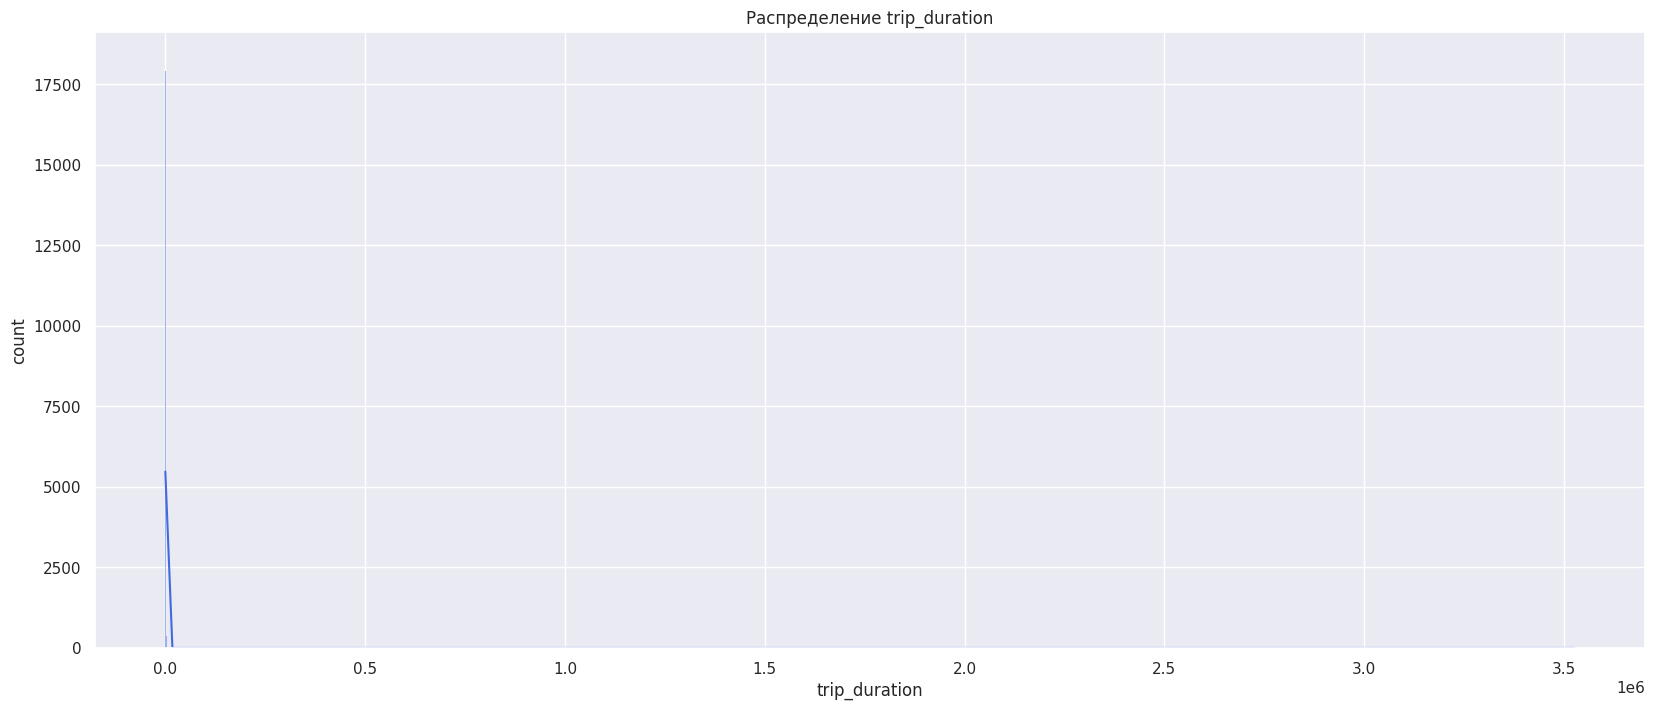

In [88]:
# ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

sns.set(rc={'figure.figsize':(20, 8)})
sns.histplot(df['trip_duration'], kde=True, color='royalblue')
plt.title('Распределение trip_duration')
plt.xlabel('trip_duration')
plt.ylabel('count')
plt.show()

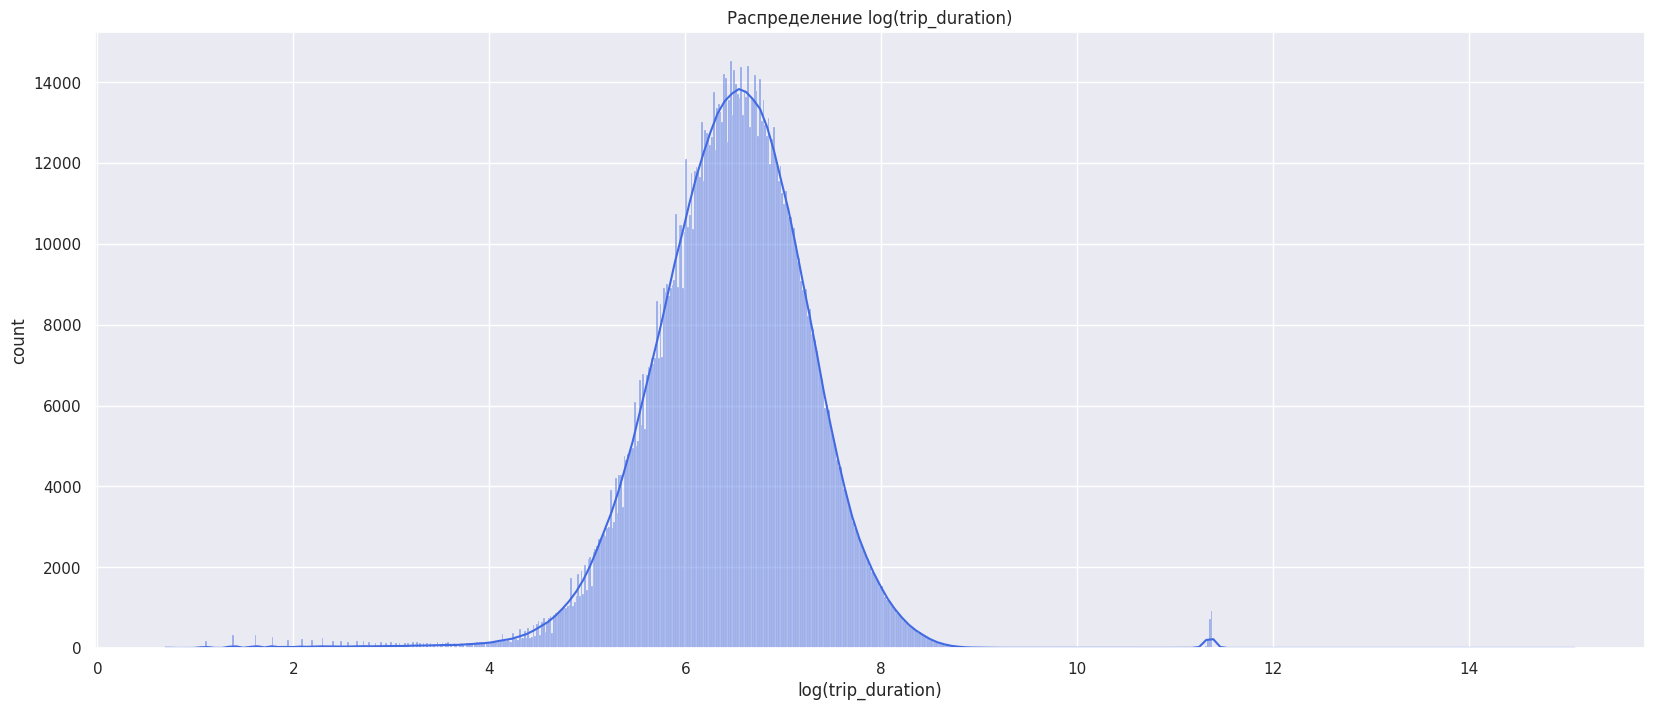

In [89]:
# как мы помним с первого семинара, если график распределения выглядит как столбец значит распределение имеет тяжёлые хвосты или есть выбросы.
# имеет смысл накинуть логарифм на эту останкинскую телебашню (законно, так как значения неотрицательные)
df['log_trip_duration'] = np.log1p(df['trip_duration'])
sns.set(rc={'figure.figsize':(20, 8)})
sns.histplot(df['log_trip_duration'], kde=True, color='royalblue')
plt.title('Распределение log(trip_duration)')
plt.xlabel('log(trip_duration)')
plt.ylabel('count')

plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?



**Ответ:** *Распределение - близкое к нормальному. Среднее время поездки такое, что логарифм от него приблизительно 7. Есть выбросы.*

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ:** *Наверное потому что нам важнее знать процентное изменение в данных, а не абсолютное. Длительности поездок раскиданы по большому диапазону. То есть при больших реальных значениях и предсказываемых мы будет иметь вменяемое значение ошибки.*

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ см. ниже

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

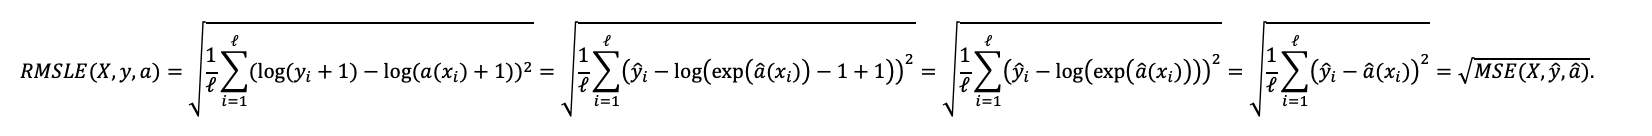

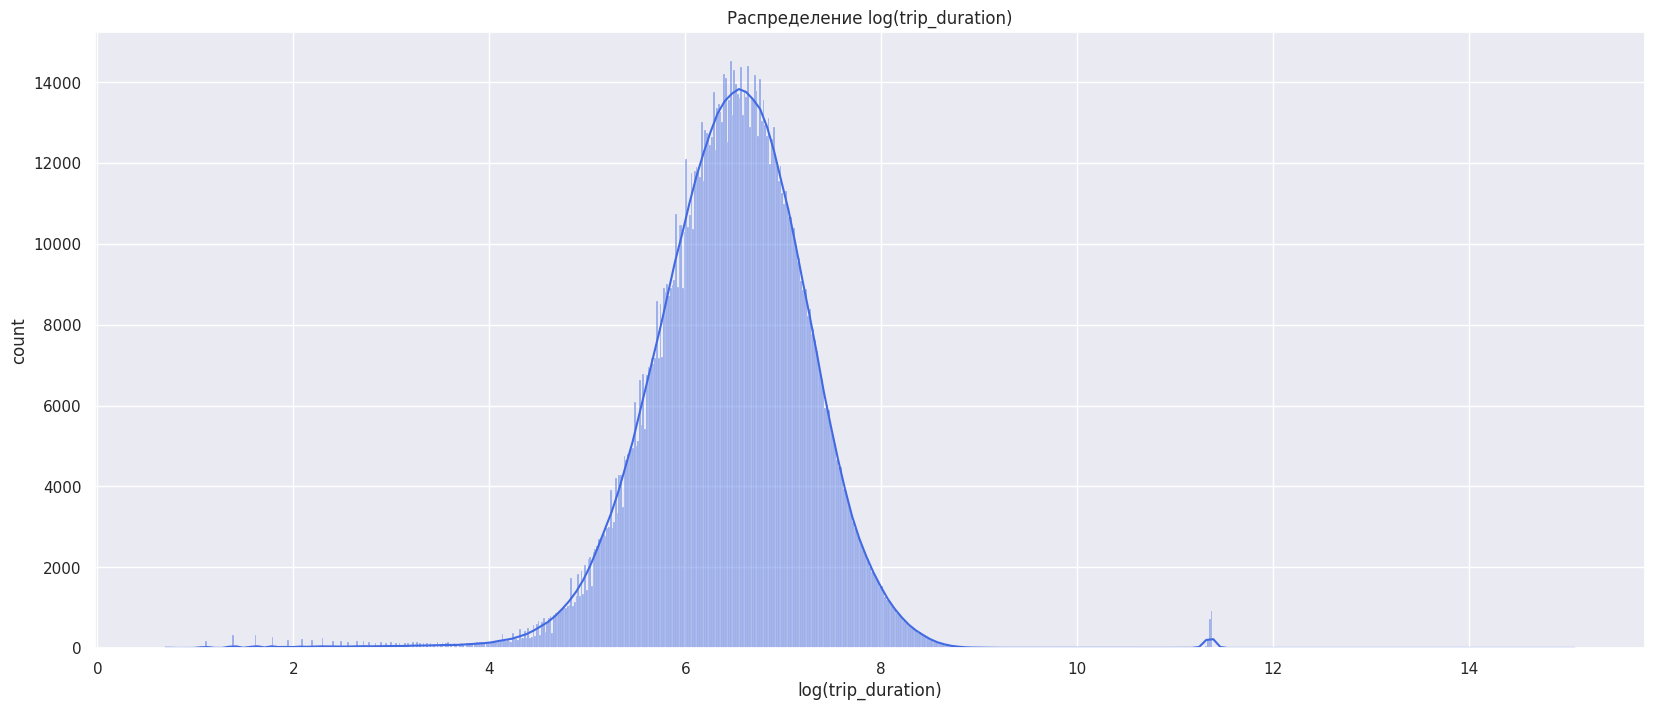

In [90]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df.drop('trip_duration', axis=1, inplace=True)
sns.set(rc={'figure.figsize':(20, 8)})
sns.histplot(df['log_trip_duration'], kde=True, color='royalblue')
plt.title('Распределение log(trip_duration)')
plt.xlabel('log(trip_duration)')
plt.ylabel('count')

plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [91]:
def rmsle(log1p_y_true, log1p_y_pred):
    #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    msle_best_const = mean_squared_error(log1p_y_true, log1p_y_pred)
    rmsle_best_const = msle_best_const ** 0.5
    return rmsle_best_const

log1p_y_pred = df['log_trip_duration']
log1p_y_true = [log1p_y_pred.mean()] * log1p_y_pred.shape[0]
rmsle_best_const = rmsle(log1p_y_true, log1p_y_pred)
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

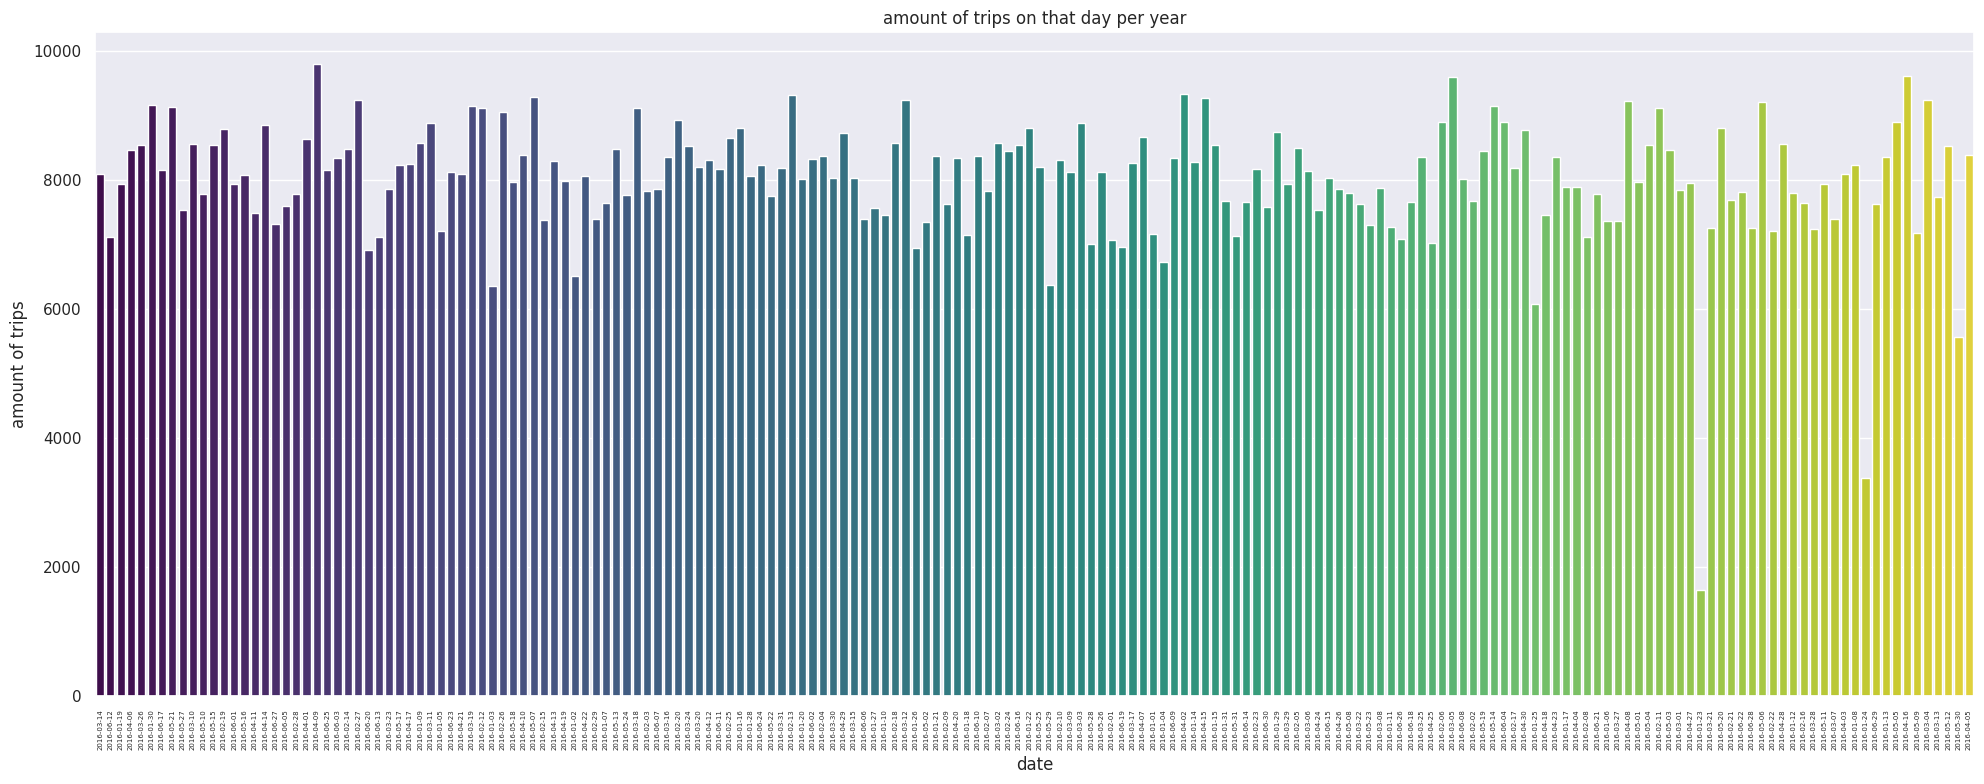

In [92]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['day_of_year'] = df['pickup_datetime'].dt.date
sns.set(rc={'figure.figsize':(20, 8)})
sns.countplot(x='day_of_year', data=df, palette='viridis')
plt.title('amount of trips on that day per year')
plt.xlabel('date')
plt.ylabel('amount of trips')
plt.xticks(rotation=90, fontsize=5)
plt.tight_layout()
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [93]:
df['pickup_datetime'].dt.date.value_counts().sort_values()

2016-01-23    1648
2016-01-24    3383
2016-05-30    5570
2016-01-25    6084
2016-01-03    6353
              ... 
2016-02-13    9309
2016-04-02    9325
2016-03-05    9597
2016-04-16    9602
2016-04-09    9796
Name: pickup_datetime, Length: 182, dtype: int64

**Ответ:** *Как можно увидеть на графике и собственно на самих значениях антипиковые дни - 23 января 2016 и 30 мая 2016.*

*2016-01-23 Нью-Йорк накрыла сильнейшая снежная буря, что сказалось на дорожной обстановке и собственно поэтому поездок было очень мало.*

[2016-05-30 в Нью-Йорке скончался попавший в аварию 24 числа кыргызстанец](https://www.zakon.kz/proisshestviia/4796029-v-nju-jjorke-skonchalsja-popavshijj-v.html) *из-за чего люди с опаской стали пользоваться автомобилями, вследствие чего уменьшился спрос на такси.*

*Прошу прощения за такие шутки. В этот день в Америке проходит Memorial Day, так что скорее всего перекрывали улицы. Также в этот день в нескольких штатах шли проливные дожди.*

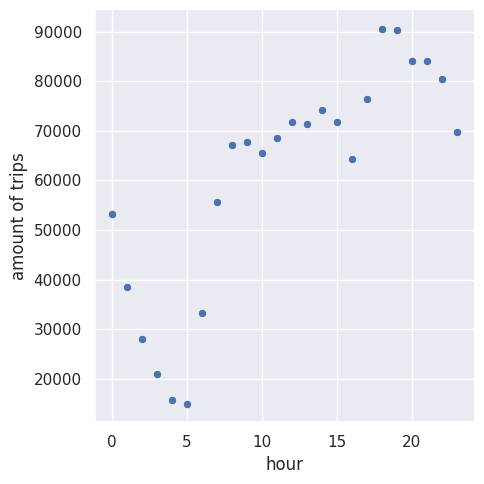

In [94]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
by_hour = np.array(df['pickup_datetime'].dt.hour.value_counts().sort_index())
sns.set(rc={'figure.figsize':(20, 8)})
sns.relplot(x=list(range(24)), y=by_hour)
plt.xlabel('hour')
plt.ylabel('amount of trips')
plt.show()

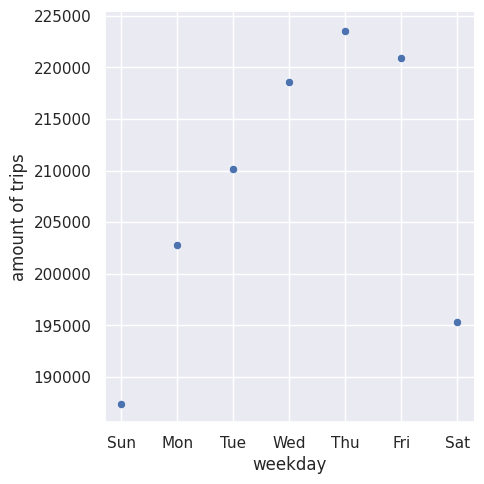

In [95]:
week = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
by_weekday = np.array(df['pickup_datetime'].dt.weekday.value_counts().sort_index())
sns.set(rc={'figure.figsize':(20, 8)})
sns.relplot(x=week, y=by_weekday)
plt.xlabel('weekday')
plt.ylabel('amount of trips')
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [96]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['month'] = df['pickup_datetime'].dt.month
df['date'] = df['pickup_datetime'].dt.date
df['weekday'] = df['pickup_datetime'].dt.weekday
df['day_of_year'] = df['pickup_datetime'].dt.day_of_year
df['hour'] = df['pickup_datetime'].dt.hour

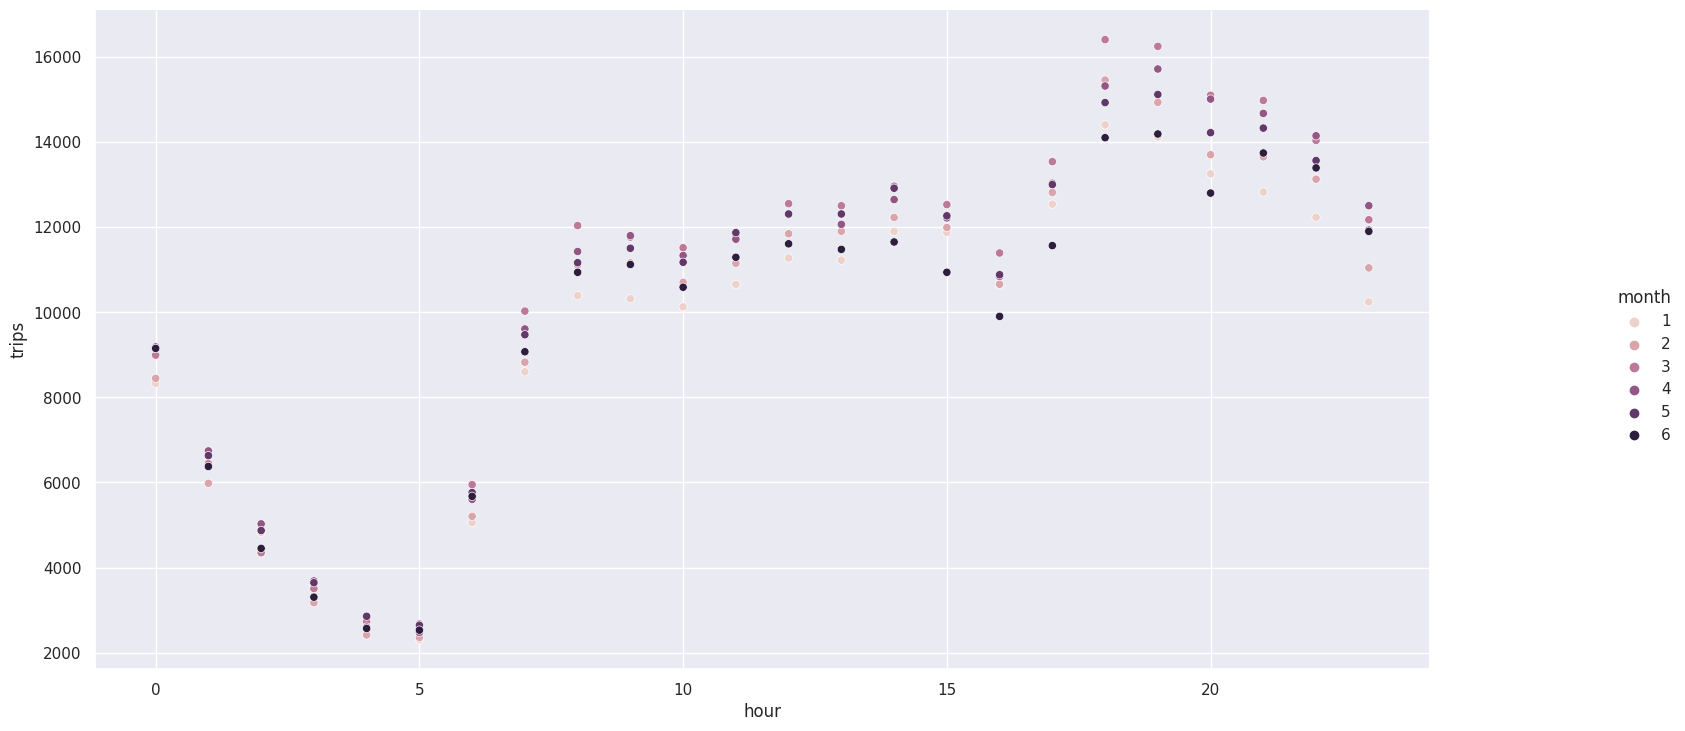

In [97]:
month_and_hour = df.groupby(['month', 'hour'])
month_and_hour = month_and_hour.agg('size').reset_index().rename(columns={0: 'trips'})
sns.relplot(data=month_and_hour, x='hour', y='trips', hue='month').figure.set_size_inches(20, 8)

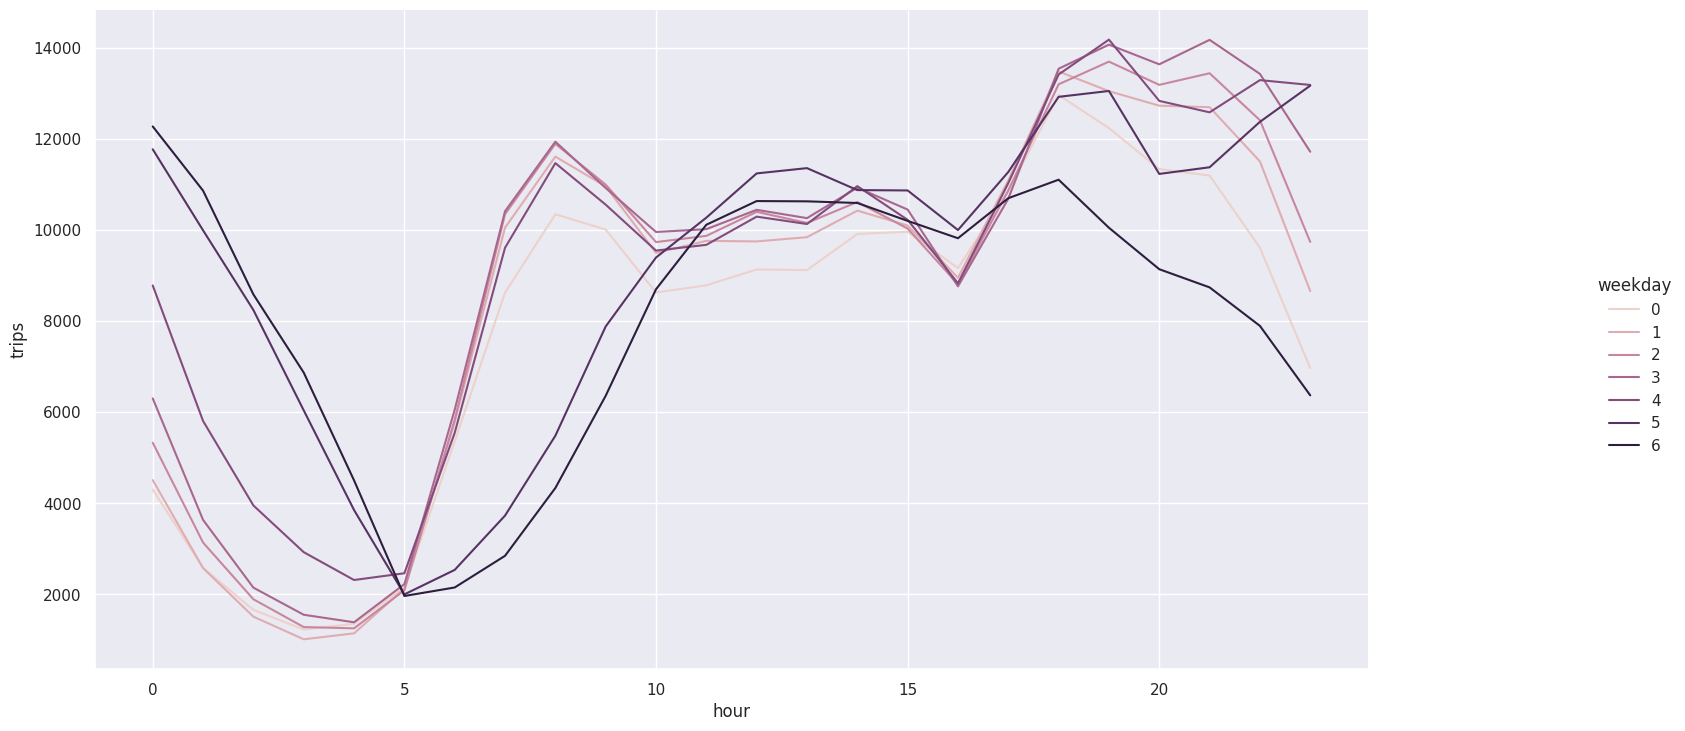

In [98]:
weekday_and_hour = df.groupby(['weekday', 'hour'])
weekday_and_hour = weekday_and_hour.agg('size').reset_index().rename(columns={0: 'trips'})
sns.relplot(data=weekday_and_hour, x='hour', y='trips', hue='weekday', kind='line').figure.set_size_inches(20, 8)

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ:** В ночной промежуток с 2 до 6 поездок мало в любом месяце. А вот с 18 до 21 всегда много (люди возвращаются домой после тяжелого рабочего дня 😁).
В пятницу и субботу ночных поездок больше, чем в другие дни (💃💃💃).

Больше всего поездок в 18 часов. \\
Меньше всего поездок в 5 утра.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [99]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X = df.drop(columns=['log_trip_duration'])
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=10)
train_df = pd.concat([X_train, y_train], axis=1)

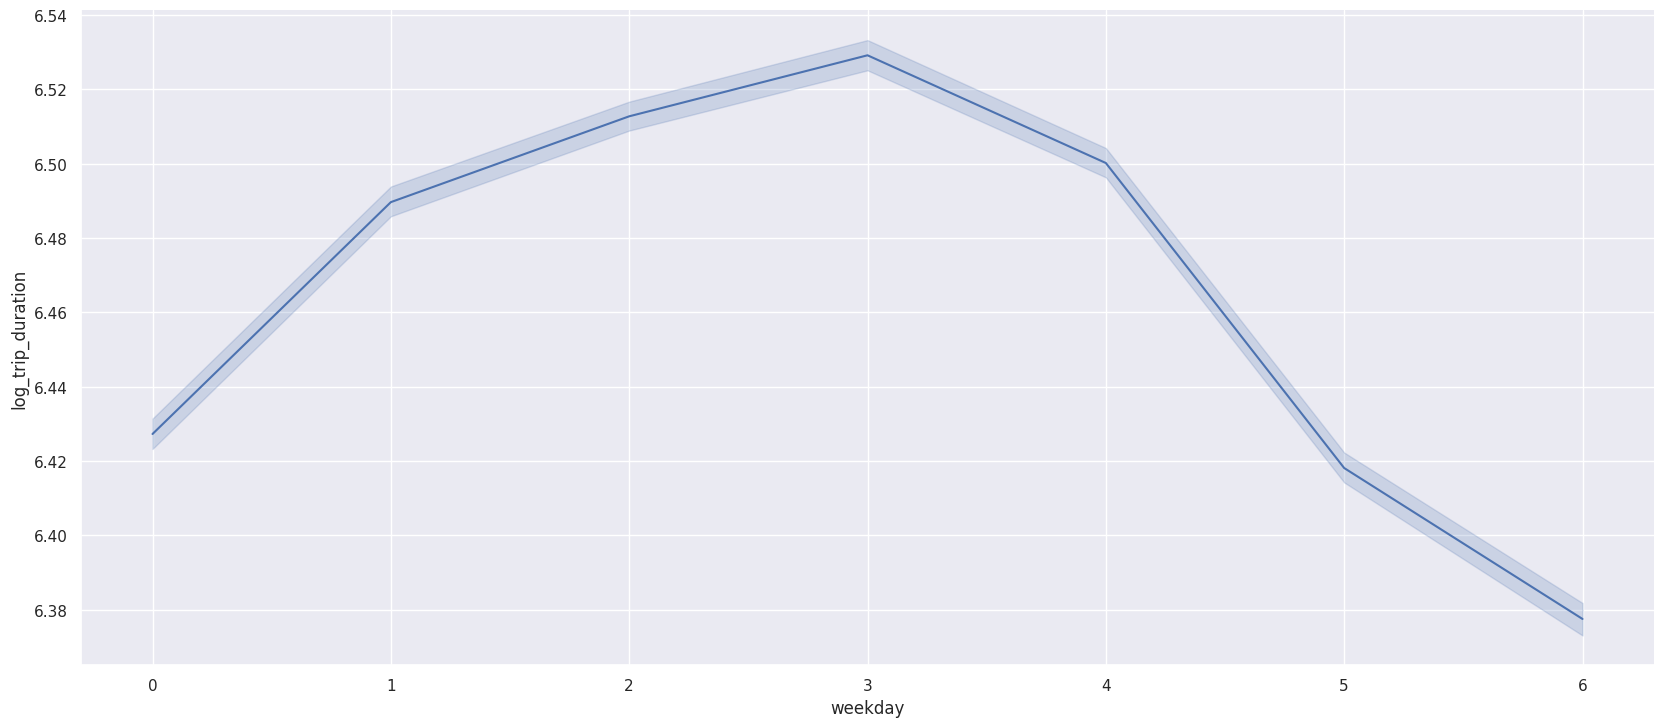

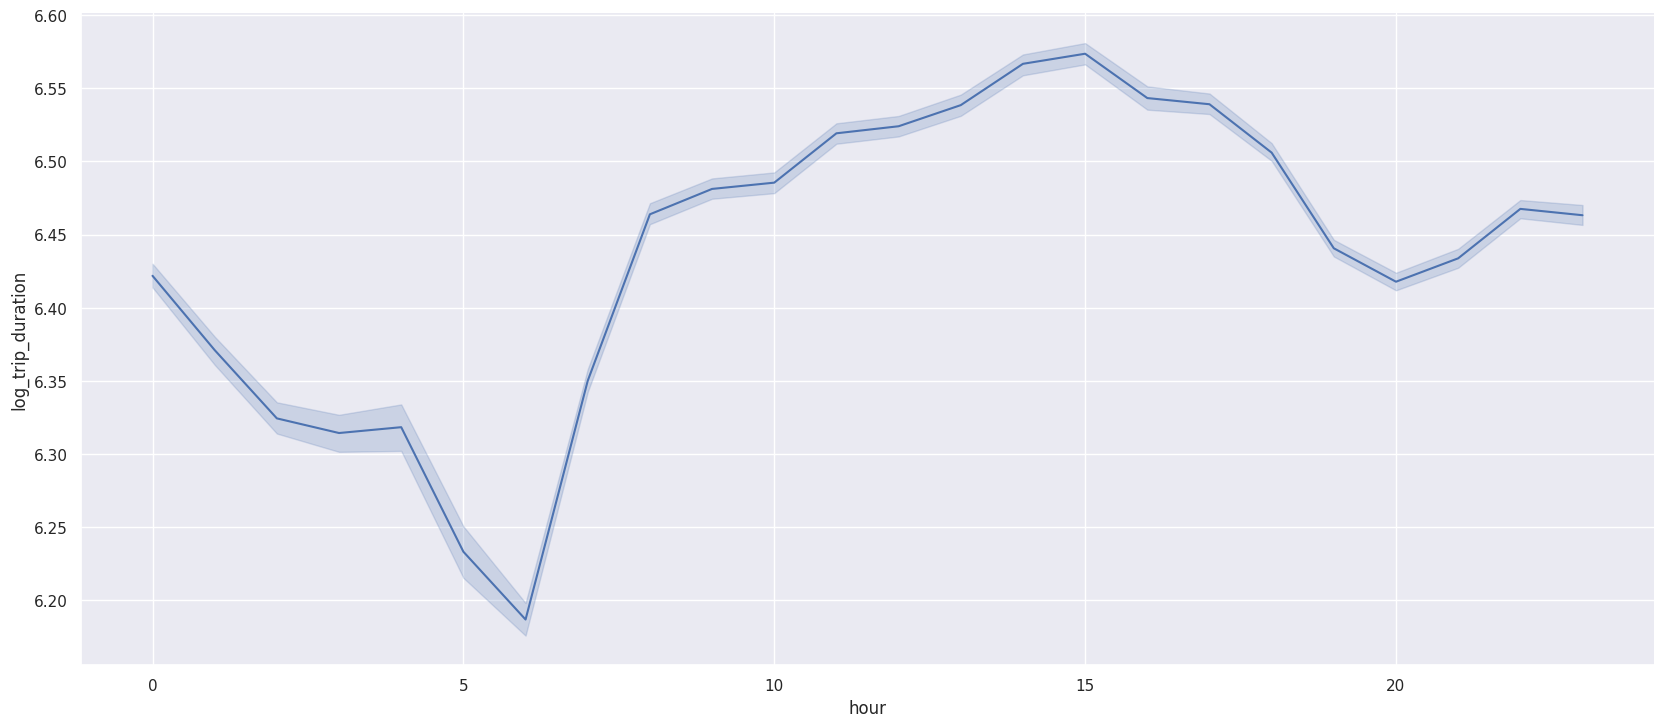

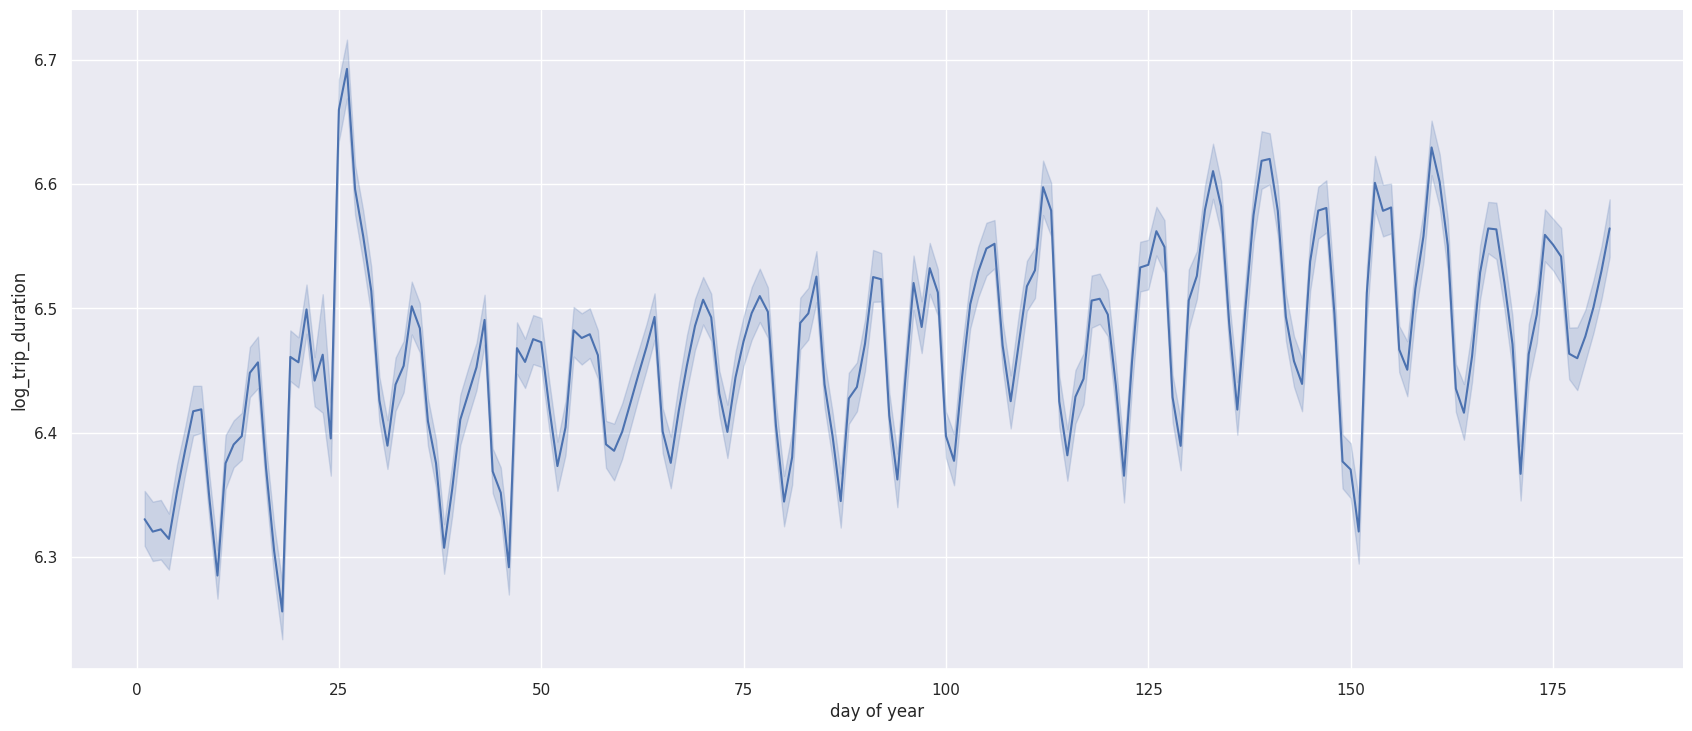

In [100]:
sns.relplot(data=train_df, x='weekday', y='log_trip_duration', estimator='mean', kind='line').set(xlabel='weekday', ylabel='log_trip_duration').figure.set_size_inches(20, 8)
sns.relplot(data=train_df, x='hour', y='log_trip_duration', estimator='mean', kind='line').set(xlabel='hour', ylabel='log_trip_duration').figure.set_size_inches(20, 8)
sns.relplot(data=train_df, x='day_of_year', y='log_trip_duration', estimator='mean', kind='line').set(xlabel='day of year', ylabel='log_trip_duration').figure.set_size_inches(20, 8)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ:** *Да, похожи. Можно заметить, что в день снежной бури длительность поездки была самой высокой, так как средняя скорость в таких условиях должна быть очень маленькой, поэтому таргет такой большой. В конце мая большинство улиц было перекрыто, поэтому поездки были короткими и соответсвенно таргет проседает. Если рассматривать день в году, то длительность поездки то возрастает, то убывает. Скорее всего это может происходить из-за погодных условий, ситуации на дорогах, праздников и дней недели.*

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [101]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['month'] = df['pickup_datetime'].dt.month
df['date'] = df['pickup_datetime'].dt.date
df['weekday'] = df['pickup_datetime'].dt.weekday
df['day_of_year'] = df['pickup_datetime'].dt.day_of_year
df['hour'] = df['pickup_datetime'].dt.hour
df['is_storm'] = df['pickup_datetime'].dt.day_of_year.isin([23, 24, 25])
df['is_holiday'] = df['pickup_datetime'].dt.day_of_year.isin([150, 151])

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

**Ответ:** Похоже, что все признаки должны быть категориальными, так как
возникает проблема обработки числовых значений, например, дня в году, часов в сутках да и просто дней недели. Если бы они были числовыми, то в модель два одинаковых по условным показателям дня, но с разными числовыми значениями, напрмер, 9 день в году и 178, давали бы разный вклад. Также и с часами и днями недели.



**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [102]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# еще раз, так как добавили новые признаки
X = df.drop(columns=['log_trip_duration'])
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=10)
train_df = pd.concat([X_train, y_train], axis=1)

In [103]:
categorical = ['weekday', 'hour', 'month', 'day_of_year', 'is_storm', 'is_holiday']
numeric = []

In [104]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred, squared=True)

print('RMSE:', rmse)
print('MSE:', mse)

RMSE: 0.7864745467944436
MSE: 0.6185422127555256


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [105]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [106]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [107]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

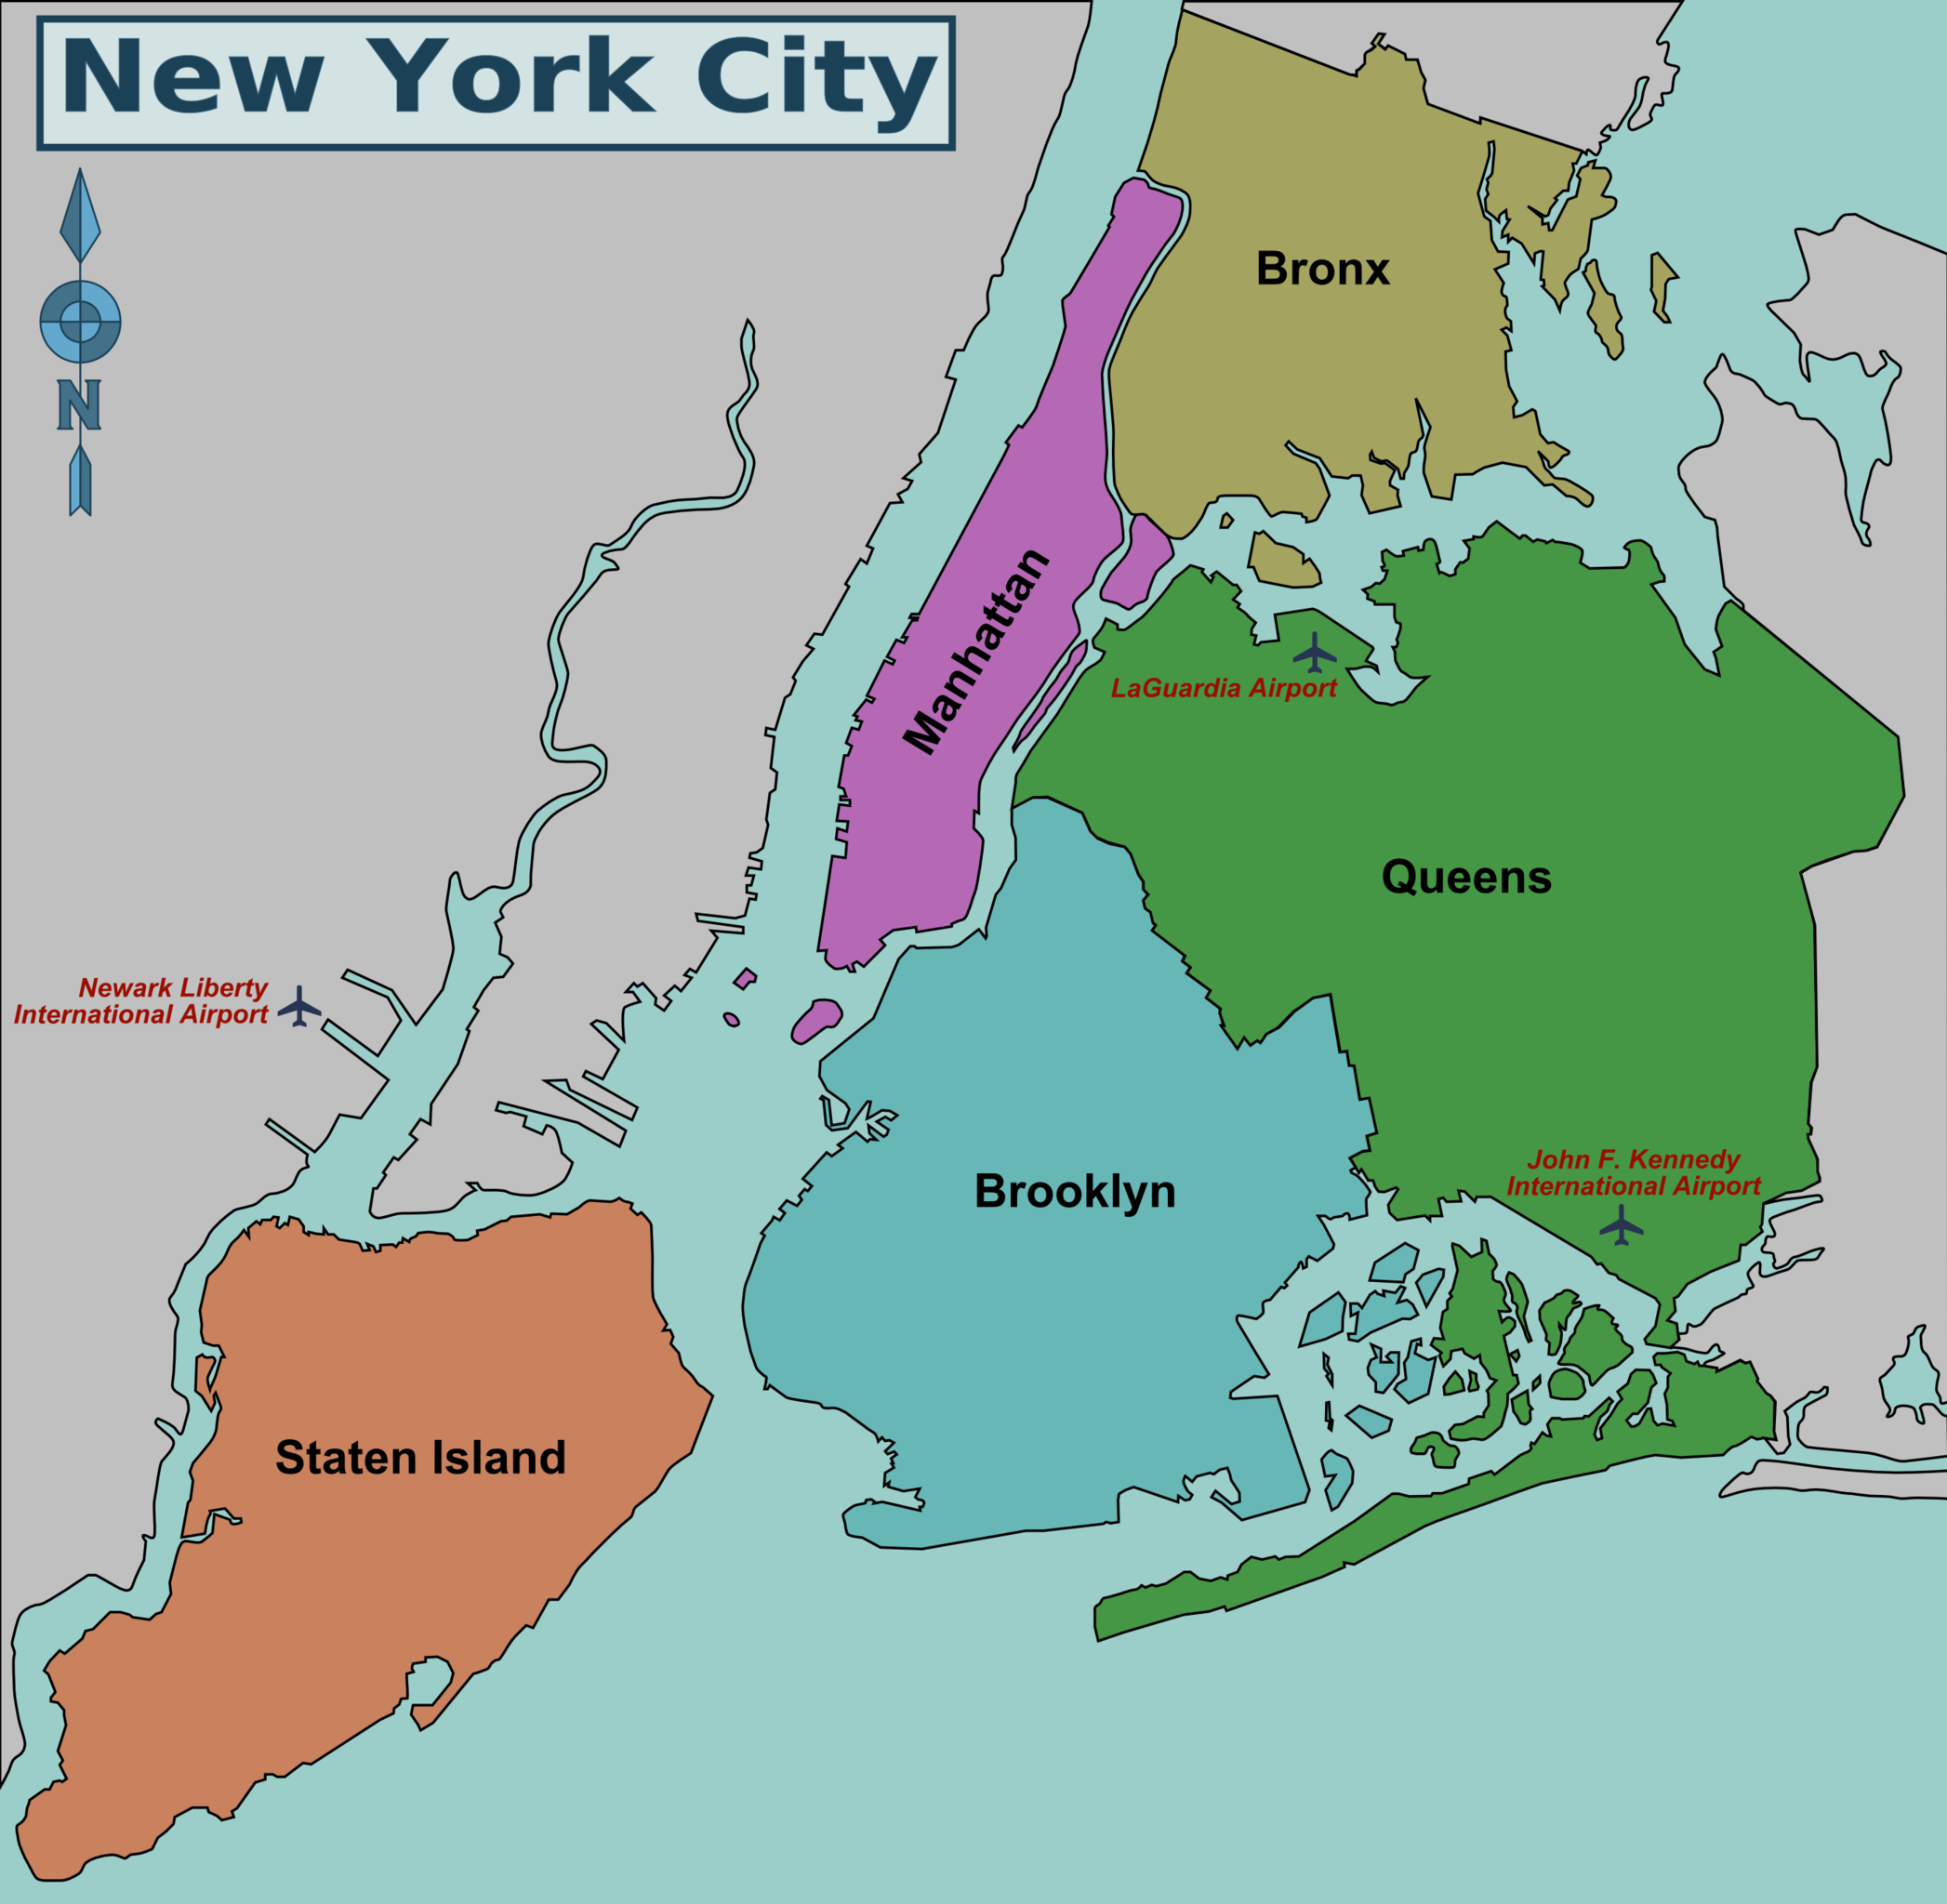

Фоточка с семинара, на которой показаны точки, с которых обычно стартуют поездки.

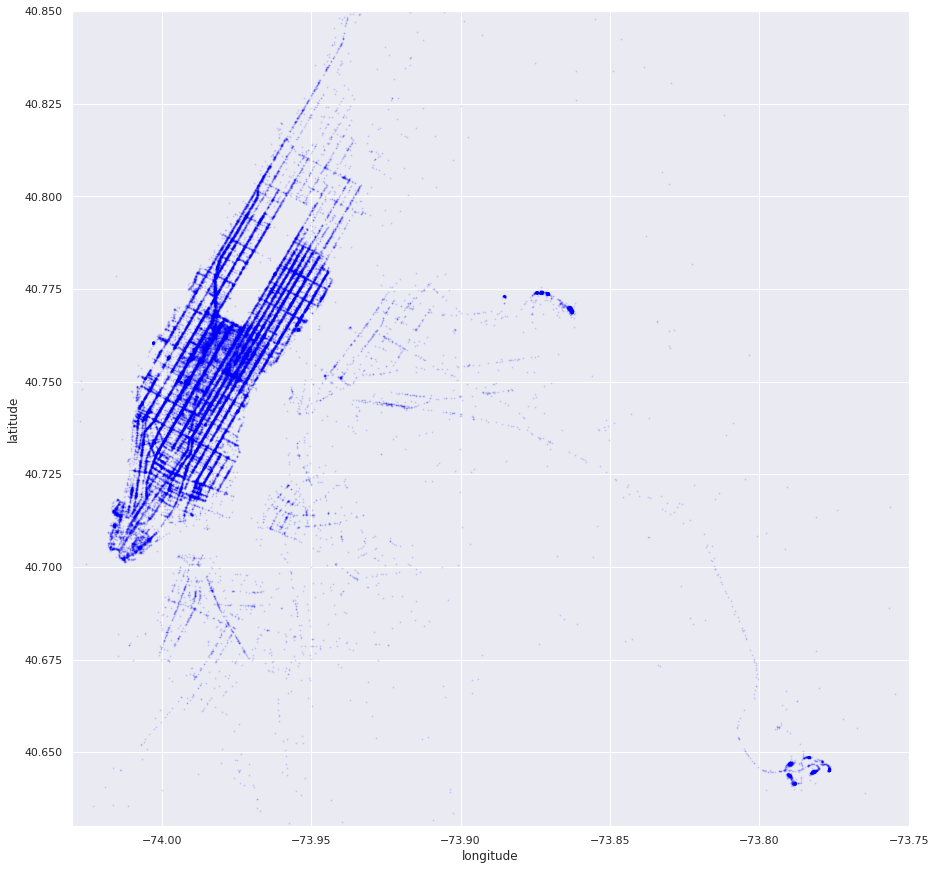

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

**Ответ:** помимо того, что мы узнали, что на Манхэттене живут мажорики, рассекающие на такси, можно заметить скопление точек в аэропортах J.F. Kennedy и LaGuardia. Причем приезжают в аэропорт на такси чаще, чем уезжают.


Предсказывать время пути до аэропорта очень важно, так как там соблюдаются строгие временнЫе правила.

Также много поездок из 42nd street port authority bus terminal, который находится на Манхэттене. Видимо люди приезжают в Нью-Йорк на автобусе, а по городу передвигаются на такси (и наоборот: приезжают на вокзал на такси, а дальше уезжают из города). Здесь тоже важно знать время поездки, чтобы не опаздывать на автобус.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [108]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# функция с семинара
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

df['haversine'] = haversine_array(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [109]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['log_haversine'] = np.log1p(df['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [110]:
your_df = df
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

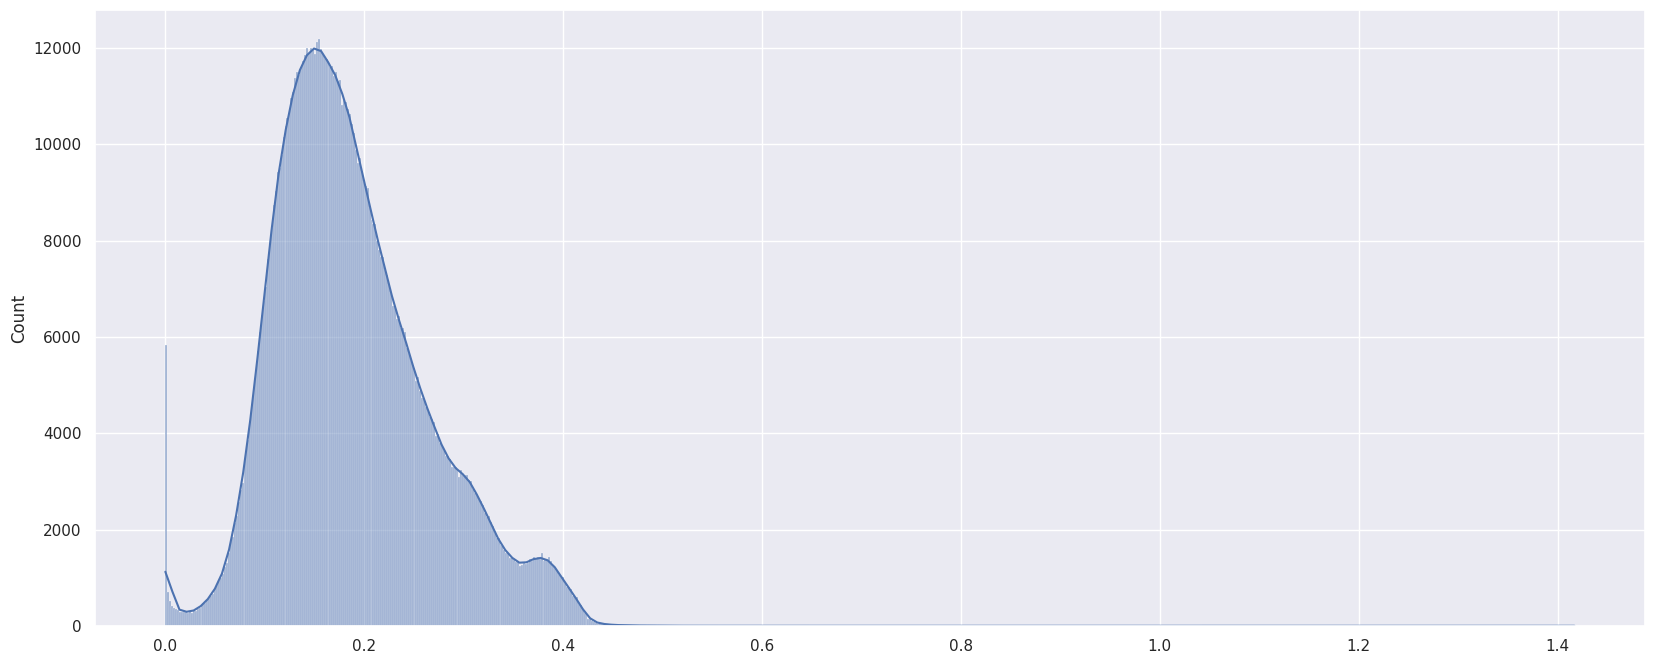

In [111]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X = df
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=10)
sns.histplot(X_train['log_haversine'] / X['log_trip_duration'], kde=True).figure.set_size_inches(20, 8)

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

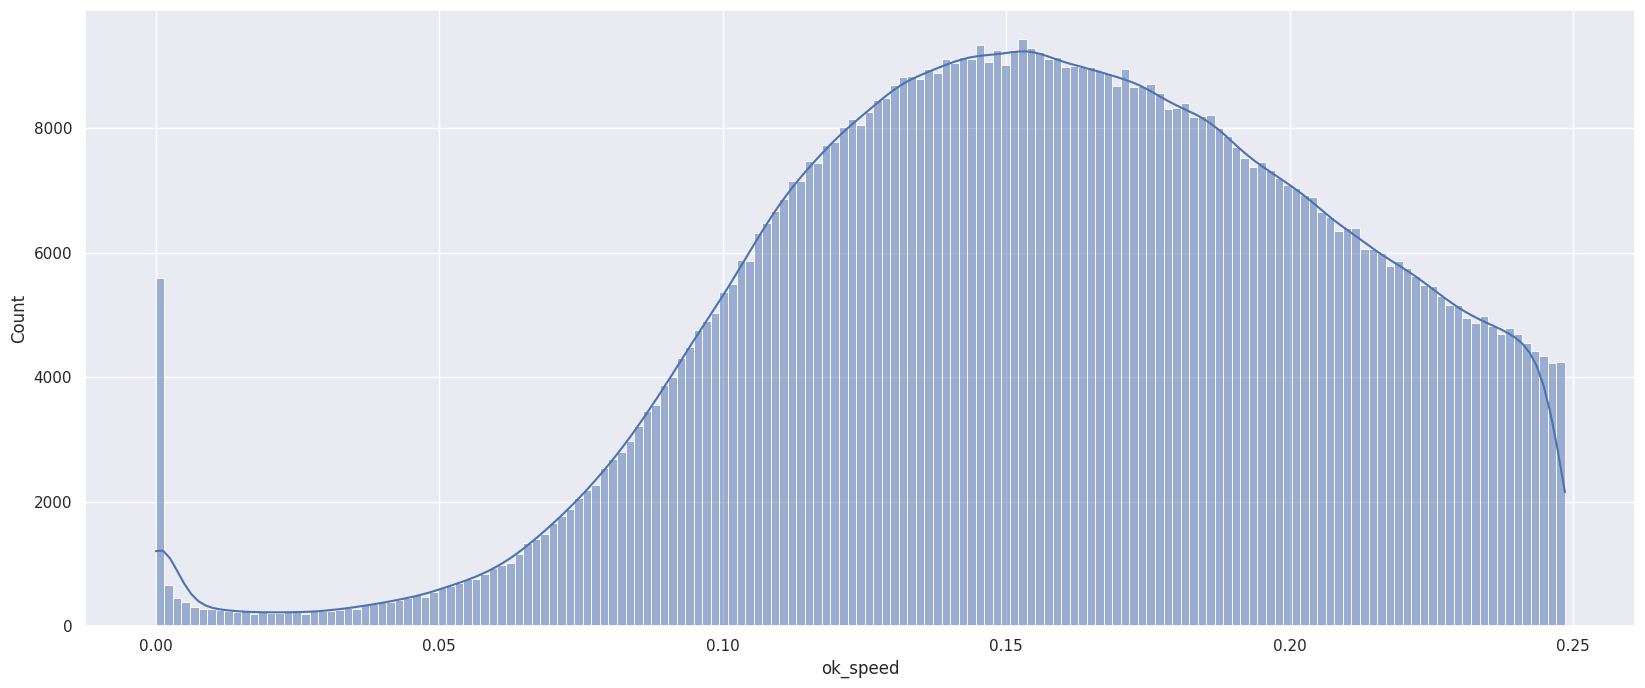

In [112]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
speed = X_train['log_haversine'] / X_train['log_trip_duration']
quantile_speed = np.quantile(speed, 0.8)
X_train['ok_speed'] = speed

X_train_slice = X_train[X_train['ok_speed'] < quantile_speed]
sns.histplot(X_train_slice['ok_speed'], kde=True).figure.set_size_inches(20, 8)

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

<ipython-input-113-cb3eed025a7b>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  mediana_speed = mediana_speed.pivot('weekday', 'hour', 'mediana_speed')


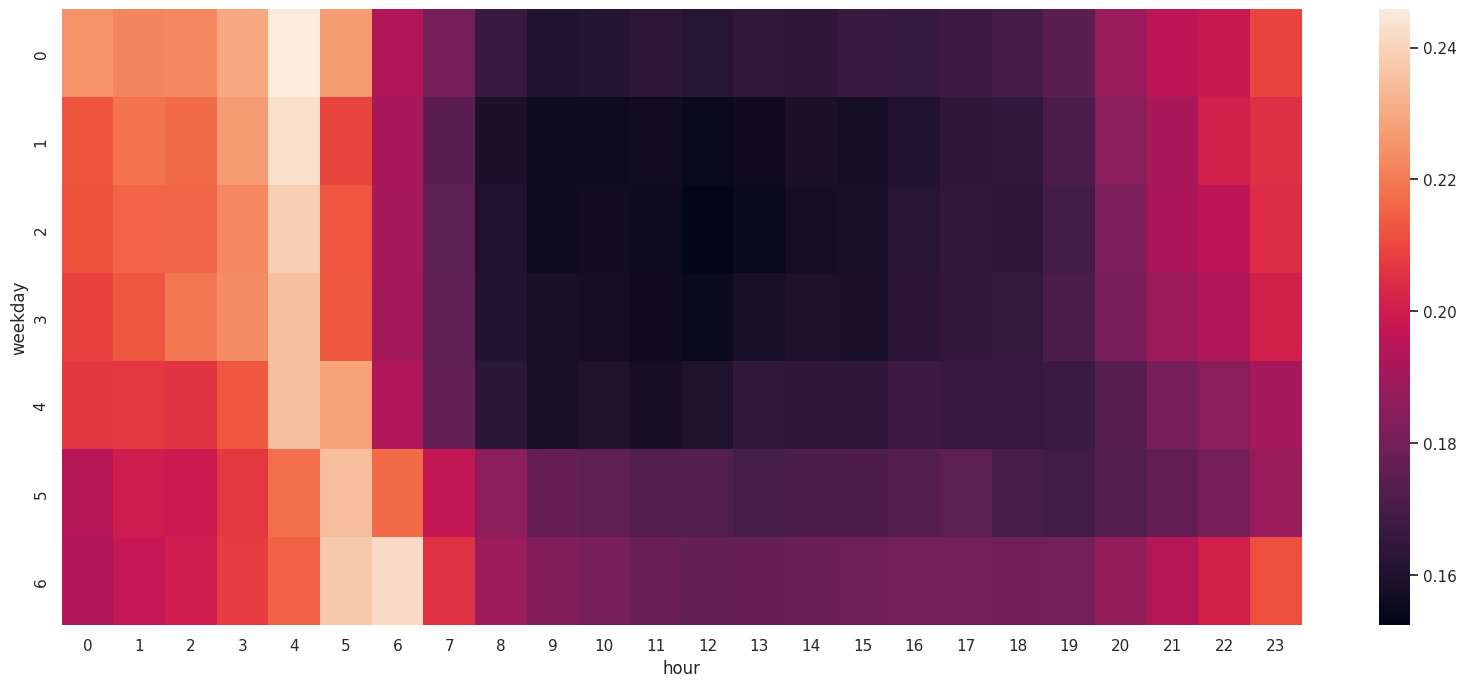

In [113]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
mediana_speed = X_train.groupby(['weekday', 'hour'])['ok_speed'].agg('median').reset_index().rename(columns={'ok_speed': 'mediana_speed'})
mediana_speed = mediana_speed.pivot('weekday', 'hour', 'mediana_speed')
sns.heatmap(mediana_speed).figure.set_size_inches(20, 8)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ:** Значение скорости нельзя использовать, так как его можно вычислить только из времени поездки, а собственно это время мы и пытаемся предсказать.

In [114]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train.drop('ok_speed', axis=1, inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

**Ответ:** В середине недели с 8 и до 15 скорость маленькая. Скорее всего из-за пробок. А вот ночью (по будням в 4, а в конце недели с 5 до 6) скорость максимальна, ввиду отсутствия тех самых пробок.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [115]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
road_status = (((df['weekday'].isin([1, 2, 3, 4])) & (df['hour'].isin([int(h) for h in range(8, 20)]))) | ((df['weekday'].isin([0, 5, 6])) & (df['hour'].isin([int(h) for h in range(9, 19)]))))
df.loc[road_status, 'is_traffic_jam'] = 1
df.loc[~road_status, 'is_traffic_jam'] = 0
df.head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:55                1   
1  id2377394          1 2016-06-12 00:43:35                1   
2  id3858529          2 2016-01-19 11:35:24                1   
3  id3504673          2 2016-04-06 19:32:31                1   
4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  log_trip_duration  day_of_year  month        date  \
0                  N           6.122493           74      3  2016-03-14   
1                  N           6.498282          164      6  2016-06-12   
2                  N           7.661527           19      1  2016-01-19   
3                  N           6.063785           97      4  2016-04-06   
4                  N           6.077642           86      3  2016-03-26   

   weekday  hour  is_storm  is_holiday  haversine  log_haversine  \
0        0    17     False       False   1.498521       0.915699   
1        6     0     False       False   1.805507       1.031584   
2        1    11     False       False   6.385098       1.999464   
3        2    19     False       False   1.485498       0.910473   
4        5    13     False       False   1.188588       0.783257   

   is_traffic_jam  
0             1.0  
1             0.0  
2             1.0  
3             1.0  
4             1.0

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [116]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# Информация из даркнета:
# аэропорт Кеннеди 40.64376500, -73.78200200
# аэропорт LaGuardia 40.7783, -73.8741
# bus terminal 40.75731, -73.98974


jfk_airport = (40.64376500, -73.78200200)
radius_for_jfk = 0.025

LaGuardia_airport = (40.7783, -73.8741)
radius_for_LaGuardia = 0.015

bus_terminal = (40.75731, -73.98974)
radius_for_bus = 0.001

In [117]:
m1 = show_circles_on_map(df[(np.abs(df['pickup_latitude'] - jfk_airport[0]) < radius_for_jfk) & (np.abs(df['pickup_longitude'] - jfk_airport[1]) < radius_for_jfk)].sample(1000), 'pickup_latitude', 'pickup_longitude', 'green')
m1

In [118]:
m2 = show_circles_on_map(df[(np.abs(df['pickup_latitude'] - LaGuardia_airport[0]) < radius_for_LaGuardia) & (np.abs(df['pickup_longitude'] - LaGuardia_airport[1]) < radius_for_LaGuardia)].sample(1000), 'pickup_latitude', 'pickup_longitude', 'green')
m2

In [119]:
m3 = show_circles_on_map(df[(np.abs(df['pickup_latitude'] - bus_terminal[0]) < radius_for_bus) & (np.abs(df['pickup_longitude'] - bus_terminal[1]) < radius_for_bus)].sample(100), 'pickup_latitude', 'pickup_longitude', 'green')
m3

In [120]:
def in_place(df, coordinates, radius, latitude, longitude, status):
    place_status = (np.abs(df[latitude] - coordinates[0]) < radius) & (np.abs(df[longitude] - coordinates[1]) < radius)
    df.loc[place_status, status] = True
    df.loc[~place_status, status] = False


in_place(df, jfk_airport, radius_for_jfk, 'pickup_latitude', 'pickup_longitude', 'pickup_in_jfk')
in_place(df, jfk_airport, radius_for_jfk, 'dropoff_latitude', 'dropoff_longitude', 'dropoff_in_jfk')

in_place(df, LaGuardia_airport, radius_for_LaGuardia, 'pickup_latitude', 'pickup_longitude', 'pickup_in_LaGuardia')
in_place(df, LaGuardia_airport, radius_for_LaGuardia, 'dropoff_latitude', 'dropoff_longitude', 'dropoff_in_LaGuardia')

in_place(df, bus_terminal, radius_for_bus, 'pickup_latitude', 'pickup_longitude', 'pickup_in_bus_terminal')
in_place(df, bus_terminal, radius_for_bus, 'dropoff_latitude', 'dropoff_longitude', 'dropoff_in_bus_terminal')

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

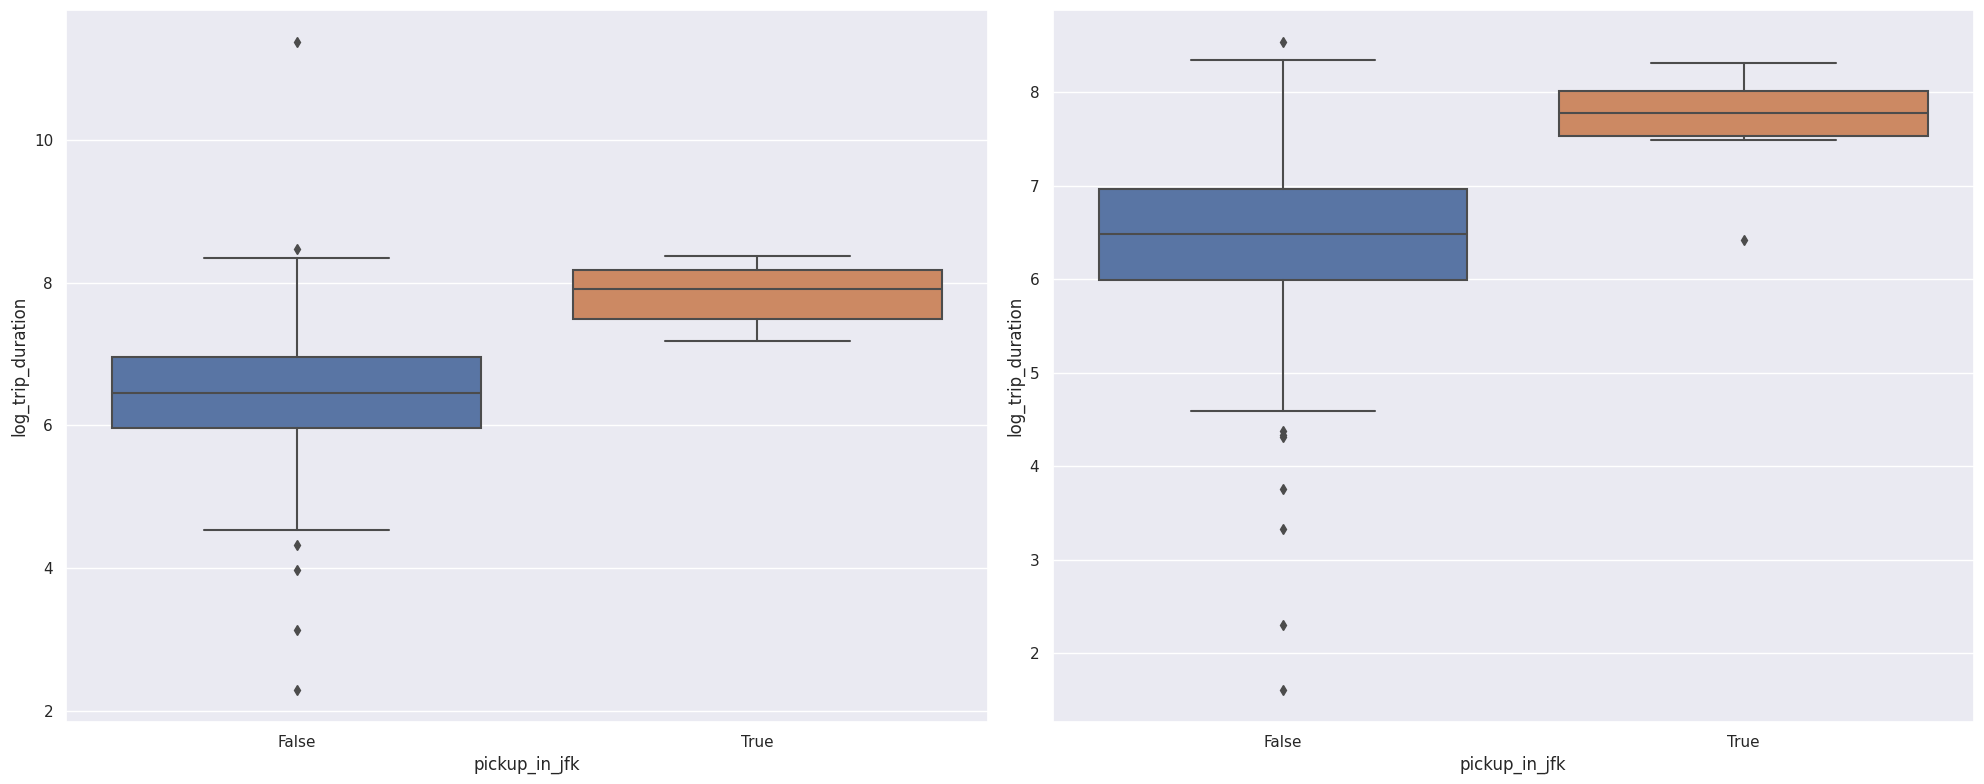

In [121]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(data=df.sample(1000), x='pickup_in_jfk', y='log_trip_duration', ax=axes[0]).set(xlabel='pickup_in_jfk', ylabel='log_trip_duration')
sns.boxplot(data=df.sample(1000), x='dropoff_in_jfk', y='log_trip_duration', ax=axes[1]).set(xlabel='pickup_in_jfk', ylabel='log_trip_duration')
plt.tight_layout()
plt.show()

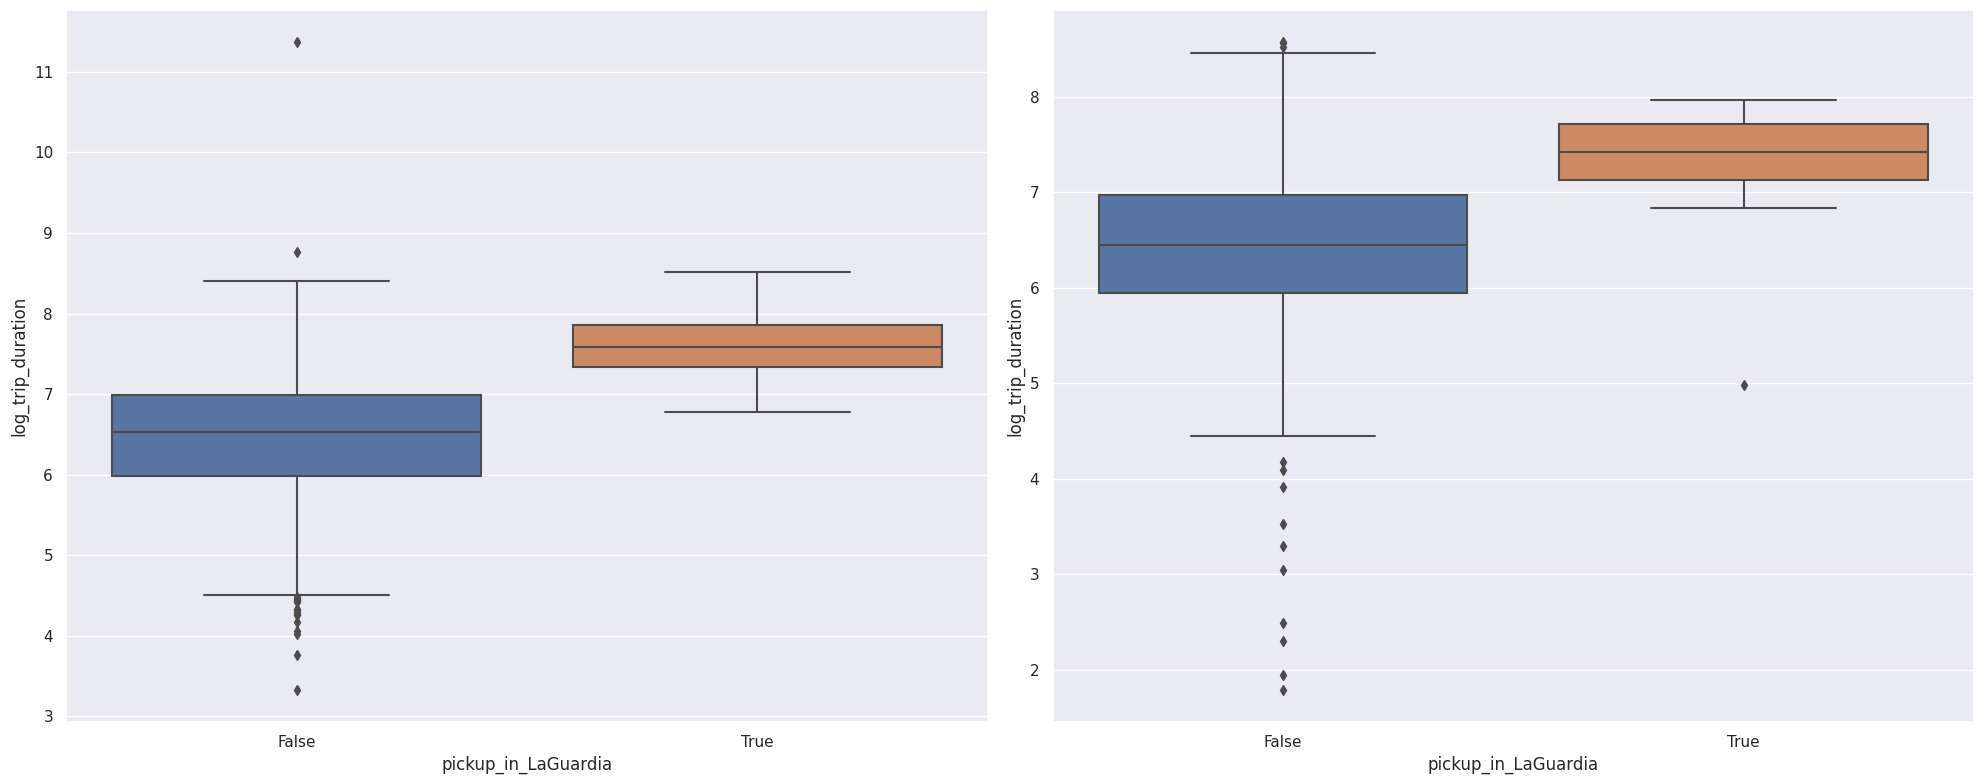

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(data=df.sample(1000), x='pickup_in_LaGuardia', y='log_trip_duration', ax=axes[0]).set(xlabel='pickup_in_LaGuardia', ylabel='log_trip_duration')
sns.boxplot(data=df.sample(1000), x='dropoff_in_LaGuardia', y='log_trip_duration', ax=axes[1]).set(xlabel='pickup_in_LaGuardia', ylabel='log_trip_duration')
plt.tight_layout()
plt.show()

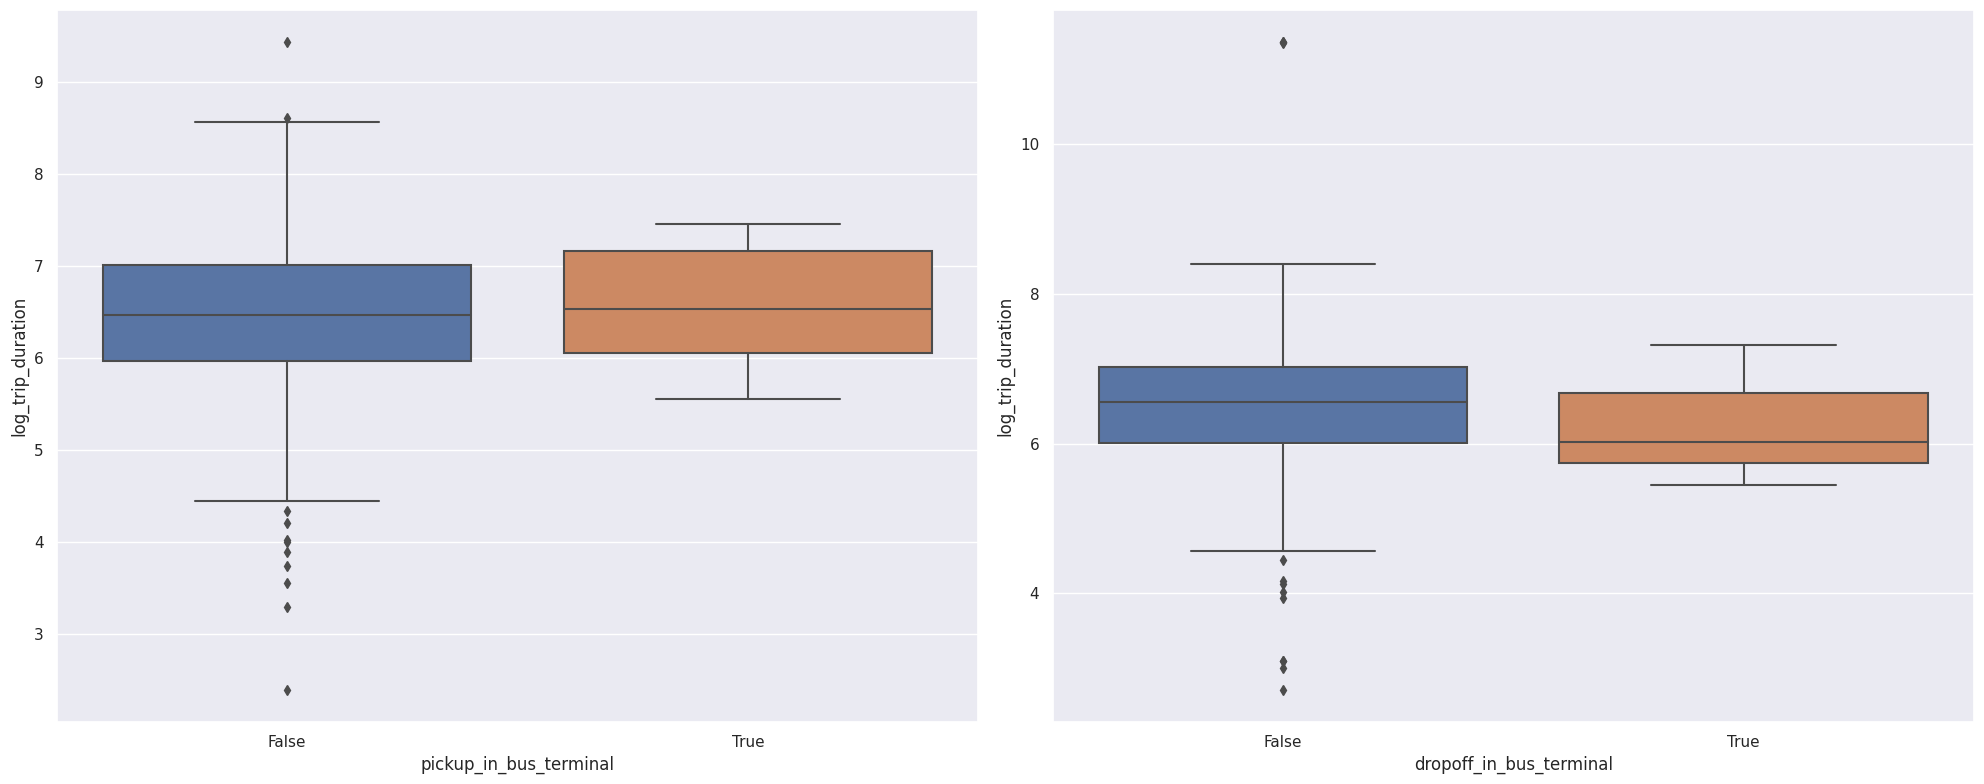

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(data=df.sample(1000), x='pickup_in_bus_terminal', y='log_trip_duration', ax=axes[0]).set(xlabel='pickup_in_bus_terminal', ylabel='log_trip_duration')
sns.boxplot(data=df.sample(1000), x='dropoff_in_bus_terminal', y='log_trip_duration', ax=axes[1]).set(xlabel='dropoff_in_bus_terminal', ylabel='log_trip_duration')
plt.tight_layout()
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ:** Во всех трех случаях распределение при начале поездки и ее окончании примерно одинаковое. Но можно заметить много выбросов, что может сказываться на нашей модели.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [124]:
from folium.vector_layers import Rectangle
East_Harlem = (40.799492, -73.936740) # правая верхняя граница
Battery_Park_City = (40.706439, -74.017589) # левая нижняя граница


def dots_in_our_area(df, right_up_coordinate, left_down_coordinate, latitude, longitude):
    return ((df[latitude] < right_up_coordinate[0]) & (df[latitude] > left_down_coordinate[0]) & (df[longitude] < right_up_coordinate[1]) & (df[longitude] > left_down_coordinate[1]))


def creation_area(df, right_up_coordinate, left_down_coordinate, latitude, longitude, height, width):
    rectangle_coordinate = []
    rectangle_height = (right_up_coordinate[0] - left_down_coordinate[0]) / height
    rectangle_width = (right_up_coordinate[1] - left_down_coordinate[1]) / width
    for x in range(width):
        for y in range(height):
            x1 = left_down_coordinate[0] + (y + 1) * rectangle_height
            y1 = left_down_coordinate[1] + (x + 1) * rectangle_width
            x2 = left_down_coordinate[0] + y * rectangle_height
            y2 = left_down_coordinate[1] + x * rectangle_width
            rectangle_coordinate.append(((x1, y1), (x2, y2)))
    return rectangle_coordinate


def show_area_with_dots(df, coordinates, latitude, longitude):
    area_center = (df[latitude].mean(), df[longitude].mean())
    m = folium.Map(location=area_center, zoom_start=10)
    for dot in coordinates:
        folium.Rectangle([dot], fill_color='blur', fill_opacity=0.6).add_to(m)

    # с семинара + выше
    for _, row in df.iterrows():
        folium.Circle(
            radius=10,
            location=(row[latitude], row[longitude]),
            color='green',
            fill_color='green',
            fill=True
        ).add_to(m)

    return m

In [125]:
is_dots_in_area = dots_in_our_area(df, East_Harlem, Battery_Park_City, 'pickup_latitude', 'pickup_longitude')
rectangles_coordinates = creation_area(df, East_Harlem, Battery_Park_City, 'pickup_latitude', 'pickup_longitude', 4, 3)
m = show_area_with_dots(df[is_dots_in_area].sample(1000), rectangles_coordinates, 'pickup_latitude', 'pickup_longitude')
m

In [126]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rectangles_coordinates):
        self.rectangles_coordinates = rectangles_coordinates
        pass

    def show_map(self, df, latitude, longitude, temp):
        # you may want to visualize cells
        area_center = (df[latitude].mean(), df[longitude].mean())
        m = folium.Map(location=area_center, zoom_start=10)

        for dot in self.rectangles_coordinates:
            folium.Rectangle([dot], fill_color='blur', fill_opacity=0.6).add_to(m)
        colors = ['red', 'orange', 'yellow', 'green', 'blue', 'royalblue', 'violet', 'brown', 'purple', 'darkgreen', 'lightgreen', 'darkblue', 'gray']

        for _, row in df.iterrows():
            pickup_area = row['pickup_in_Manhattan']
            if pickup_area >= 0:
                color = colors[pickup_area % len(colors)]
            else:
                color = 'gray'
            folium.Circle(
                radius=10,
                location=(row[latitude], row[longitude]),
                color=color,
                fill_color=color,
                fill=True
            ).add_to(m)

        return m


    def fit(self, X=None, y=None):
        # your code here
        return self

    def transform(self, X, y=None):
        # your code here
        X = X.copy()
        X['pickup_in_Manhattan'] = -1
        X['dropoff_in_Manhattan'] = -1
        for cur_area, dot in enumerate(self.rectangles_coordinates):
            X.loc[dots_in_our_area(X, dot[0], dot[1], 'pickup_latitude', 'pickup_longitude'), 'pickup_in_Manhattan'] = cur_area
            X.loc[dots_in_our_area(X, dot[0], dot[1], 'dropoff_latitude', 'dropoff_longitude'), 'dropoff_in_Manhattan'] = cur_area
        return X

In [127]:
# проверим, что все работает
map_grid_transformer = MapGridTransformer(rectangles_coordinates)
df = map_grid_transformer.transform(df)
m = map_grid_transformer.show_map(df.sample(1000), 'pickup_latitude', 'pickup_longitude', 'pickup_in_Manhattan')
m

In [128]:
df[df['pickup_in_Manhattan'] != -1].head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:55                1   
1  id2377394          1 2016-06-12 00:43:35                1   
2  id3858529          2 2016-01-19 11:35:24                1   
3  id3504673          2 2016-04-06 19:32:31                1   
4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  log_trip_duration  ...  log_haversine  is_traffic_jam  \
0                  N           6.122493  ...       0.915699             1.0   
1                  N           6.498282  ...       1.031584             0.0   
2                  N           7.661527  ...       1.999464             1.0   
3                  N           6.063785  ...       0.910473             1.0   
4                  N           6.077642  ...       0.783257             1.0   

  pickup_in_jfk  dropoff_in_jfk  pickup_in_LaGuardia  dropoff_in_LaGuardia  \
0         False           False                False                 False   
1         False           False                False                 False   
2         False           False                False                 False   
3         False           False                False                 False   
4         False           False                False                 False   

   pickup_in_bus_terminal  dropoff_in_bus_terminal  pickup_in_Manhattan  \
0                   False                    False                    6   
1                   False                    False                    5   
2                   False                    False                    6   
3                   False                    False                    0   
4                   False                    False                    7   

   dropoff_in_Manhattan  
0                     6  
1                     1  
2                     0  
3                     0  
4                     7  

[5 rows x 28 columns]

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [129]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X = df.drop(columns=['log_trip_duration'])
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=10)
train_df = pd.concat([X_train, y_train], axis=1)

In [130]:
categorical = ['weekday', 'hour', 'month', 'day_of_year', 'is_storm', 'is_holiday', 'is_traffic_jam', 'pickup_in_jfk', 'dropoff_in_jfk', 'pickup_in_LaGuardia', 'dropoff_in_LaGuardia', 'pickup_in_bus_terminal', 'dropoff_in_bus_terminal', 'pickup_in_Manhattan', 'dropoff_in_Manhattan']
numeric = ['log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred, squared=True)

print('RMSE:', rmse)
print('MSE:', mse)

RMSE: 0.47572664458636194
MSE: 0.22631584036939875


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

**Ответ:**

 * vendor_id может влиять на класс заказов (например, бизнес или эконом, то есть целевая аудитория фирм может быть разной) и соответственно на их длительность.

 * passenger_count влияет на количество точек посадки или высадки, тем самым увеличивая (или уменьшая) продолжительность поездки.


 * store_and_fwd_flag скорее всего может указать на выбросы, так как продолжительность поездки может меняться из-за отложенной отправки данных.




*   **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
*   **vendor_id** - a code indicating the provider associated with the trip record
* **passenger_count** - the number of passengers in the vehicle (driver entered value)


In [131]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print('Количество уникальных значений vendor_id: ', len(df['vendor_id'].value_counts()))
print('Количество уникальных значений passenger_count: ', len(df['passenger_count'].value_counts()))
print('Количество уникальных значений store_and_fwd_flag: ', len(df['store_and_fwd_flag'].value_counts()))

Количество уникальных значений vendor_id:  2
Количество уникальных значений passenger_count:  10
Количество уникальных значений store_and_fwd_flag:  2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

[Text(0.5, 0, 'vendor_id'), Text(0, 0.5, 'log_trip_duration')]

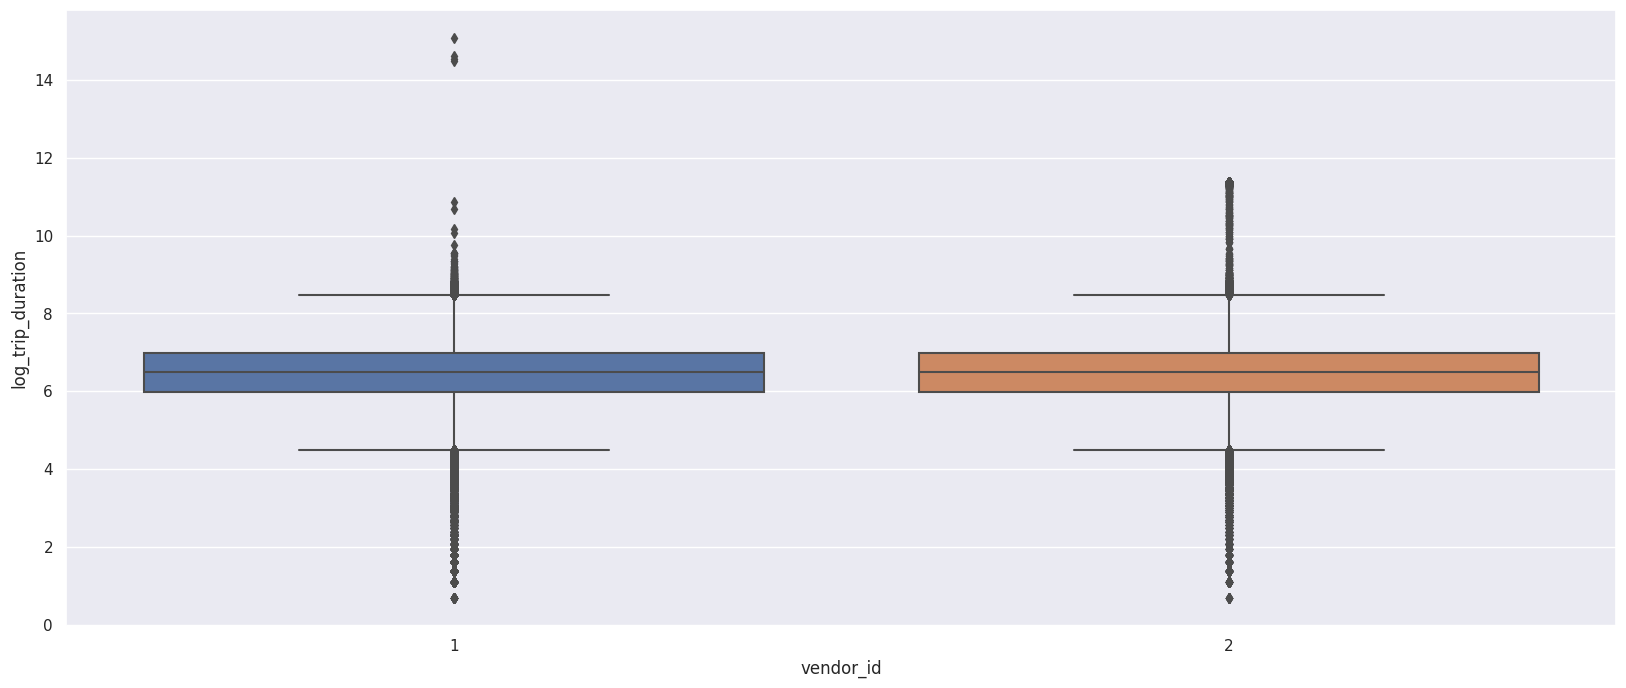

In [132]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
sns.boxplot(data=df, x='vendor_id', y='log_trip_duration').set(xlabel='vendor_id', ylabel='log_trip_duration')

[Text(0.5, 0, 'passenger_count'), Text(0, 0.5, 'log_trip_duration')]

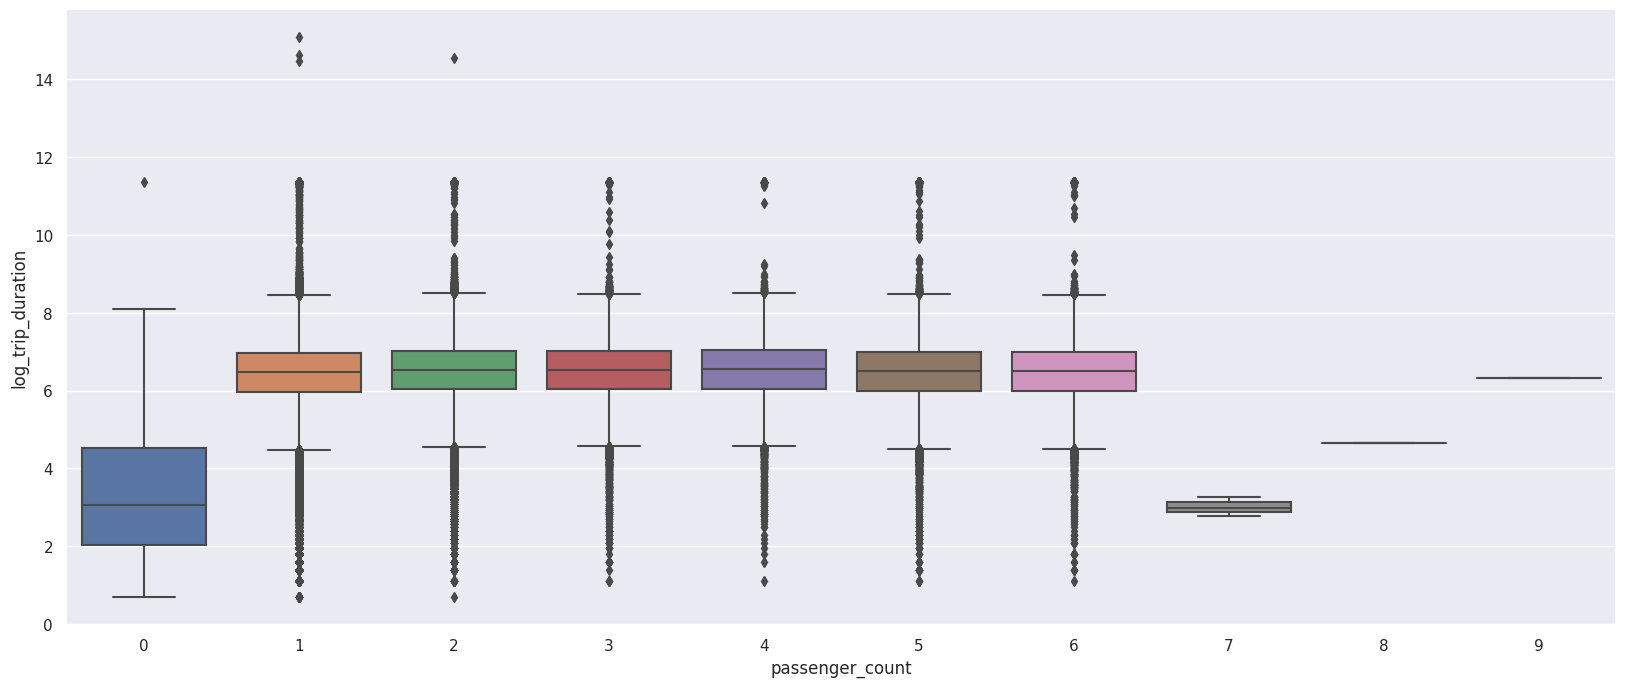

In [133]:
sns.boxplot(data=df, x='passenger_count', y='log_trip_duration').set(xlabel='passenger_count', ylabel='log_trip_duration')

[Text(0.5, 0, 'store_and_fwd_flag'), Text(0, 0.5, 'log_trip_duration')]

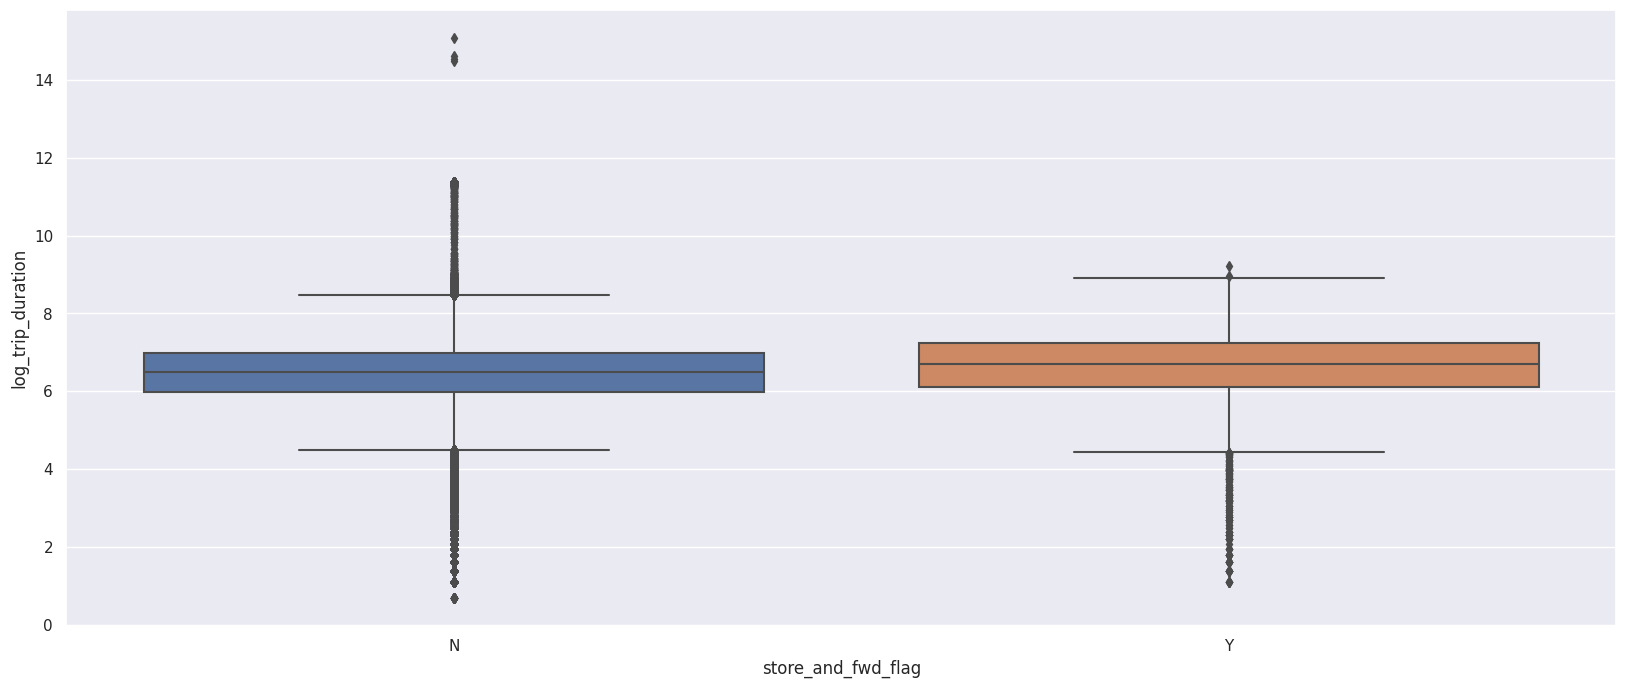

In [134]:
sns.boxplot(data=df, x='store_and_fwd_flag', y='log_trip_duration').set(xlabel='store_and_fwd_flag', ylabel='log_trip_duration')

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [135]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df.loc[df['vendor_id'] == 1, 'vendor_id'] = 0
df.loc[df['vendor_id'] == 2, 'vendor_id'] = 1
df.loc[df['store_and_fwd_flag'] == 'N', 'store_and_fwd_flag'] = 0
df.loc[df['store_and_fwd_flag'] == 'Y', 'store_and_fwd_flag'] = 1

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ:** Кажется, что признаки почти бесполезны. Забавляют поездки с нулем пассажиров. Видимо некоторые водители не заполняли эти данные. А для стандартного количества пассажиров (1-5) распределения практически одинаковые. Для большего количества пассажиров уже автобус какой то получается и таких поездок мало.
На всех данных есть выбросы.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [136]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X = df
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=10)
train_df = pd.concat([X_train, y_train], axis=1)

In [137]:
categorical = ['weekday', 'hour', 'month', 'day_of_year', 'is_storm', 'is_holiday', 'is_traffic_jam', 'pickup_in_jfk', 'dropoff_in_jfk', 'pickup_in_LaGuardia', 'dropoff_in_LaGuardia', 'pickup_in_bus_terminal', 'dropoff_in_bus_terminal', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pickup_in_Manhattan', 'dropoff_in_Manhattan']
numeric = ['log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred, squared=True)

print('RMSE:', rmse)
print('MSE:', mse)

RMSE: 0.47544123481805395
MSE: 0.2260443677653159


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [138]:
print('Улучшено на:', 0.47572664458636194 - 0.47544123481805395)

Улучшено на: 0.00028540976830798703


In [139]:
# поэтому "до свидания"
df.drop(columns=['vendor_id', 'passenger_count', 'store_and_fwd_flag'], inplace=True)

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [140]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# кажется намечается жесткое редактирование df, поэтому чтобы все не испортить создадим копию
df_backup = df.copy()

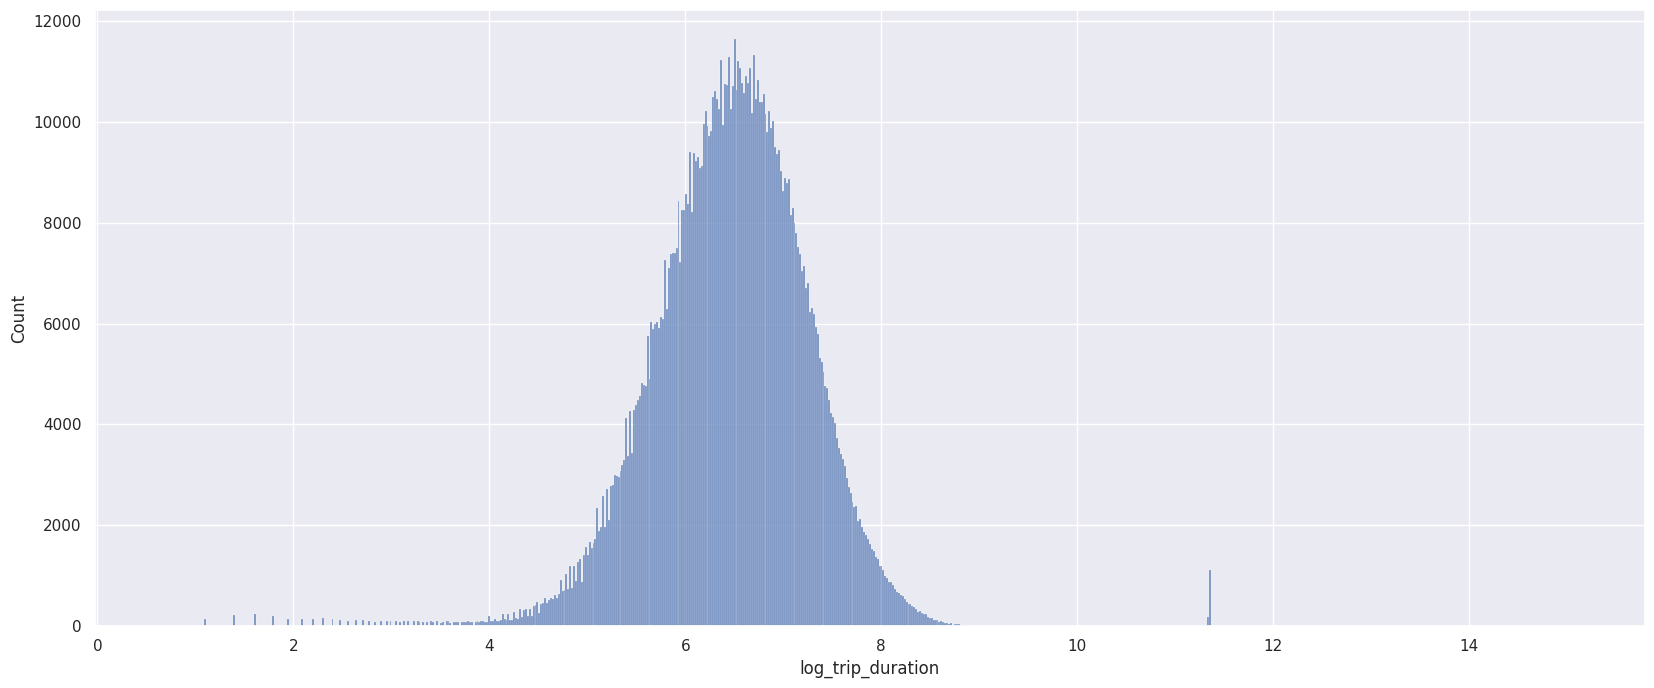

In [141]:
sns.histplot(X_train['log_trip_duration']).figure.set_size_inches(20, 8)

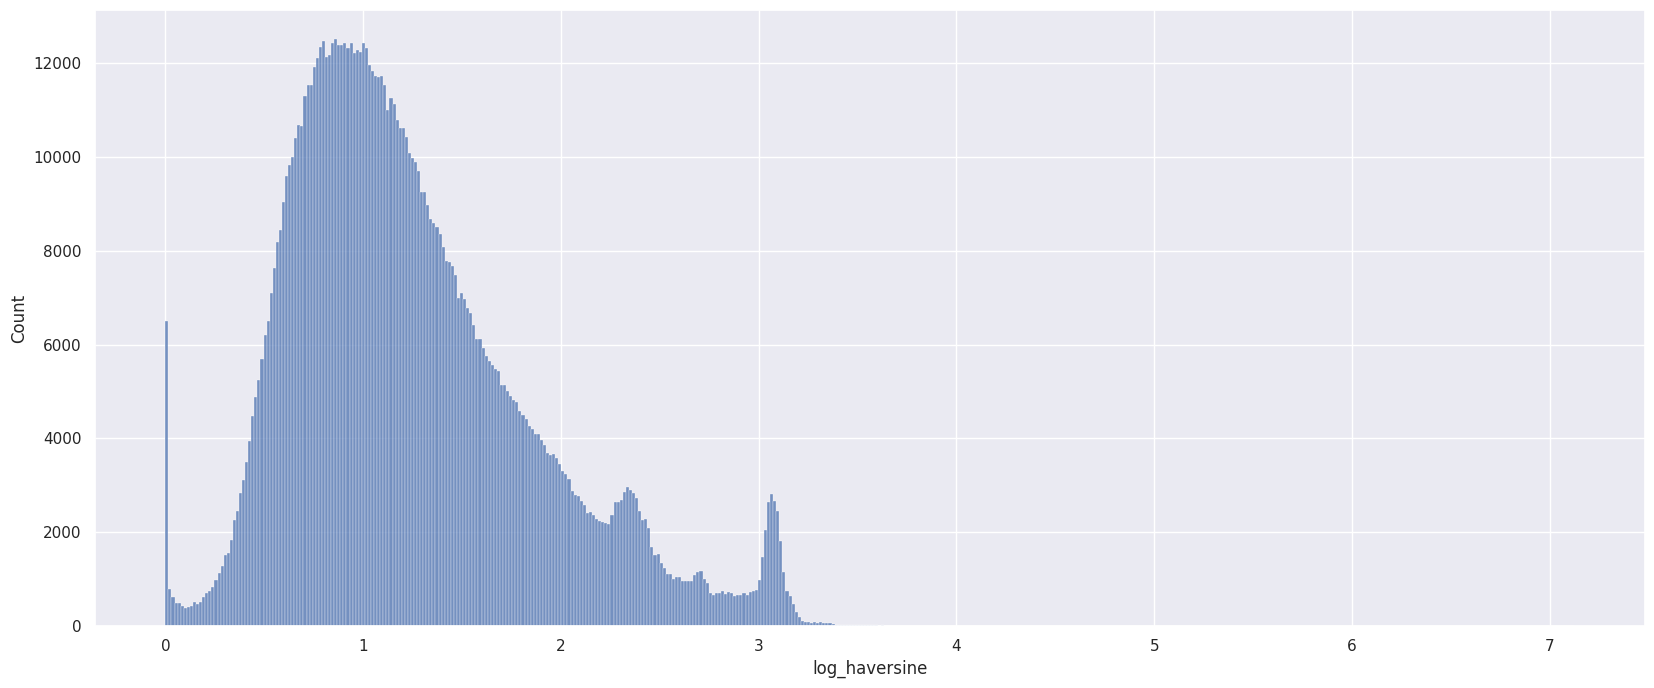

In [142]:
sns.histplot(X_train['log_haversine']).figure.set_size_inches(20, 8)

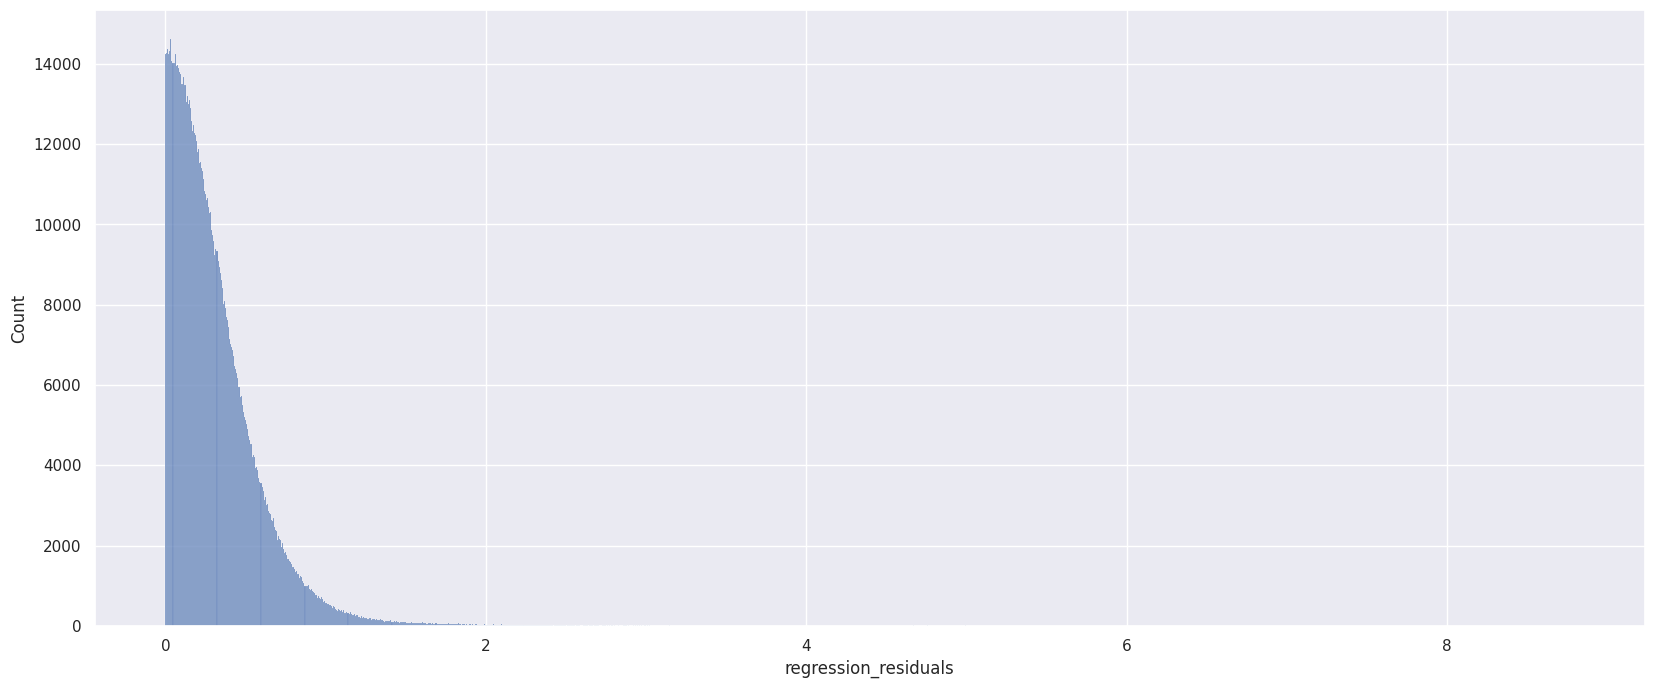

In [143]:
X_train['predict'] = model.predict(X_train)
X_train['regression_residuals'] = np.abs(X_train['predict'] - X_train['log_trip_duration'])
sns.histplot(X_train['regression_residuals']).figure.set_size_inches(20, 8)

In [144]:
X_train = X_train[X_train['log_trip_duration'] > 3.5]
X_train = X_train[X_train['log_haversine'] < 3.5]
X_train = X_train[X_train['regression_residuals'] < 2]
X_train.head()

id  vendor_id     pickup_datetime  passenger_count  \
824746   id2365163          1 2016-03-27 00:25:29                3   
645821   id3126187          1 2016-03-18 20:44:12                1   
691846   id2588127          1 2016-04-15 18:26:12                2   
1147931  id0915715          1 2016-03-24 14:28:34                1   
183569   id3758776          0 2016-04-28 13:53:52                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
824746         -73.996986        40.742210         -73.987740   
645821         -73.989929        40.741760         -73.977280   
691846         -73.972366        40.750725         -73.861832   
1147931        -73.982361        40.776901         -73.975128   
183569         -73.973778        40.764374         -73.966957   

         dropoff_latitude store_and_fwd_flag  log_trip_duration  ...  \
824746          40.710659                  0           7.134891  ...   
645821          40.783600                  0           6.878326  ...   
691846          40.768387                  0           7.642524  ...   
1147931         40.760921                  0           6.888572  ...   
183569          40.761024                  0           6.177944  ...   

         pickup_in_jfk  dropoff_in_jfk pickup_in_LaGuardia  \
824746           False           False               False   
645821           False           False               False   
691846           False           False               False   
1147931          False           False               False   
183569           False           False               False   

         dropoff_in_LaGuardia  pickup_in_bus_terminal  \
824746                  False                   False   
645821                  False                   False   
691846                   True                   False   
1147931                 False                   False   
183569                  False                   False   

         dropoff_in_bus_terminal  pickup_in_Manhattan  dropoff_in_Manhattan  \
824746                     False                    1                     4   
645821                     False                    5                     7   
691846                     False                    5                    -1   
1147931                    False                    7                     6   
183569                     False                    6                     6   

          predict  regression_residuals  
824746   6.649148              0.485743  
645821   6.902487              0.024160  
691846   7.624109              0.018415  
1147931  6.485013              0.403560  
183569   5.969401              0.208543  

[5 rows x 30 columns]

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [145]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print('Количество категориальных признаков:', len(categorical))
print(categorical)

Количество категориальных признаков: 18
['weekday', 'hour', 'month', 'day_of_year', 'is_storm', 'is_holiday', 'is_traffic_jam', 'pickup_in_jfk', 'dropoff_in_jfk', 'pickup_in_LaGuardia', 'dropoff_in_LaGuardia', 'pickup_in_bus_terminal', 'dropoff_in_bus_terminal', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pickup_in_Manhattan', 'dropoff_in_Manhattan']


In [146]:
# действительно много, можно попробовать объединить некоторые признаки в один, но качество при этом ухудшается
# X_train['bad_weather_or_holiday'] = X_train['is_storm'] | X_train['is_holiday']
# X_train['airport_jfk'] = X_train['pickup_in_jfk'] | X_train['dropoff_in_jfk']
# X_train['airport_lg'] = X_train['pickup_in_LaGuardia'] | X_train['dropoff_in_LaGuardia']
# X_train['terminal'] = X_train['pickup_in_bus_terminal'] | X_train['dropoff_in_bus_terminal']
# поэтому посмотрим на сами значения признаков

In [147]:
X_train['weekday'].value_counts()

4    155726
5    153778
3    151766
2    146109
1    140819
6    135440
0    130432
Name: weekday, dtype: int64

In [148]:
X_train['hour'].value_counts()

19    62950
18    62835
21    58552
20    58473
22    55901
17    53208
14    51719
12    50155
15    50084
13    49695
23    48529
11    47686
9     46955
8     46709
10    45329
16    44748
7     38696
0     37080
1     26881
6     22949
2     19312
3     14425
4     10936
5     10263
Name: hour, dtype: int64

In [149]:
X_train['day_of_year'].value_counts()

100    6900
65     6706
107    6694
44     6498
99     6466
       ... 
150    4358
25     4287
151    3845
24     2354
23     1152
Name: day_of_year, Length: 182, dtype: int64

Никакие значения особо не выделяются, так что глобального смысла их трогать нет

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [150]:
categorical = ['weekday', 'hour', 'month', 'day_of_year', 'is_storm', 'is_holiday', 'is_traffic_jam', 'pickup_in_jfk', 'dropoff_in_jfk', 'pickup_in_LaGuardia', 'dropoff_in_LaGuardia', 'pickup_in_bus_terminal', 'dropoff_in_bus_terminal', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pickup_in_Manhattan', 'dropoff_in_Manhattan']
numeric = ['log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[categorical + numeric], X_train['log_trip_duration'])
y_pred = model.predict(X_test[categorical + numeric])

rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred, squared=True)

print('RMSE:', rmse)
print('MSE:', mse)

RMSE: 0.4757541961053886
MSE: 0.22634205511188454


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [151]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print('Количество признаков до OneHot-кодирования:', len(categorical + numeric))
print('Количество признаков после OneHot-кодирования:', column_transformer.transform(X_train).shape[1])

Количество признаков до OneHot-кодирования: 19
Количество признаков после OneHot-кодирования: 276


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [152]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import Lasso

categorical = ['weekday', 'hour', 'month', 'day_of_year', 'is_storm', 'is_holiday', 'is_traffic_jam', 'pickup_in_jfk', 'dropoff_in_jfk', 'pickup_in_LaGuardia', 'dropoff_in_LaGuardia', 'pickup_in_bus_terminal', 'dropoff_in_bus_terminal', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pickup_in_Manhattan', 'dropoff_in_Manhattan']
numeric = ['log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = pipeline.fit(X_train[categorical + numeric], X_train['log_trip_duration'])
y_pred = model.predict(X_test[categorical + numeric])

rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred, squared=True)

print('LASSO RMSE:', rmse)
print('LASSO MSE:', mse)

LASSO RMSE: 0.7942987062552074
LASSO MSE: 0.6309104347586961


**Ответ:** Существенно хуже, чем уже привычная Ridge регрессия. Для приемлемых результатов нужно подбирать параметры регуляризации.

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [153]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import GridSearchCV

values_alpha = np.logspace(-5, 5, 10)
cv = GridSearchCV(estimator=Ridge(), param_grid={'alpha': values_alpha}, scoring='neg_root_mean_squared_error', cv=5, verbose=1)

pipeline = Pipeline(steps=[
    ('transform', column_transformer),
    ('cv', cv)
])

model = pipeline.fit(X_train[categorical + numeric], X_train['log_trip_duration'])
y_pred = model.predict(X_test[categorical + numeric])

ridge_rmse = mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False)
best_alpha_ridge = cv.best_params_['alpha']
print('Ridge RMSE:', ridge_rmse)
print('Лучший alpha:', best_alpha_ridge)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Ridge RMSE: 0.4757543873725985
Лучший alpha: 3.593813663804626


In [154]:
values_alpha = np.logspace(-3, 5, 10)
cv = GridSearchCV(estimator=Lasso(), param_grid={'alpha': values_alpha}, scoring='neg_root_mean_squared_error', cv=5, verbose=1)

pipeline = Pipeline(steps=[
    ('transform', column_transformer),
    ('cv', cv)
])

model = pipeline.fit(X_train[categorical + numeric], X_train['log_trip_duration'])
y_pred = model.predict(X_test[categorical + numeric])

lasso_rmse = mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False)
best_alpha_lasso = cv.best_params_['alpha']
print('LASSO RMSE:', lasso_rmse)
print('Лучший alpha:', best_alpha_lasso)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
LASSO RMSE: 0.48079377744125334
Лучший alpha: 0.001


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [155]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print('Сейчас:', column_transformer.transform(X_train).shape[1], '\n', 'хотим хотя бы:', column_transformer.transform(X_train).shape[1] // 2)

Сейчас: 276 
 хотим хотя бы: 138


In [156]:
def zero_weight(values_alpha):
    num_zero_weights = []

    for alpha in values_alpha:
        pipeline = Pipeline(steps=[
            ('transform', column_transformer),
            ('regression', Lasso(alpha))
        ])
        model = pipeline.fit(X_train[categorical + numeric], X_train['log_trip_duration'])
        zero_weights = (model.named_steps['regression'].coef_ == 0).sum()
        num_zero_weights.append(zero_weights)

    return num_zero_weights


In [157]:
zero_alpha = zero_weight(values_alpha)
zero_alpha

[219, 265, 275, 275, 276, 276, 276, 276, 276, 276]

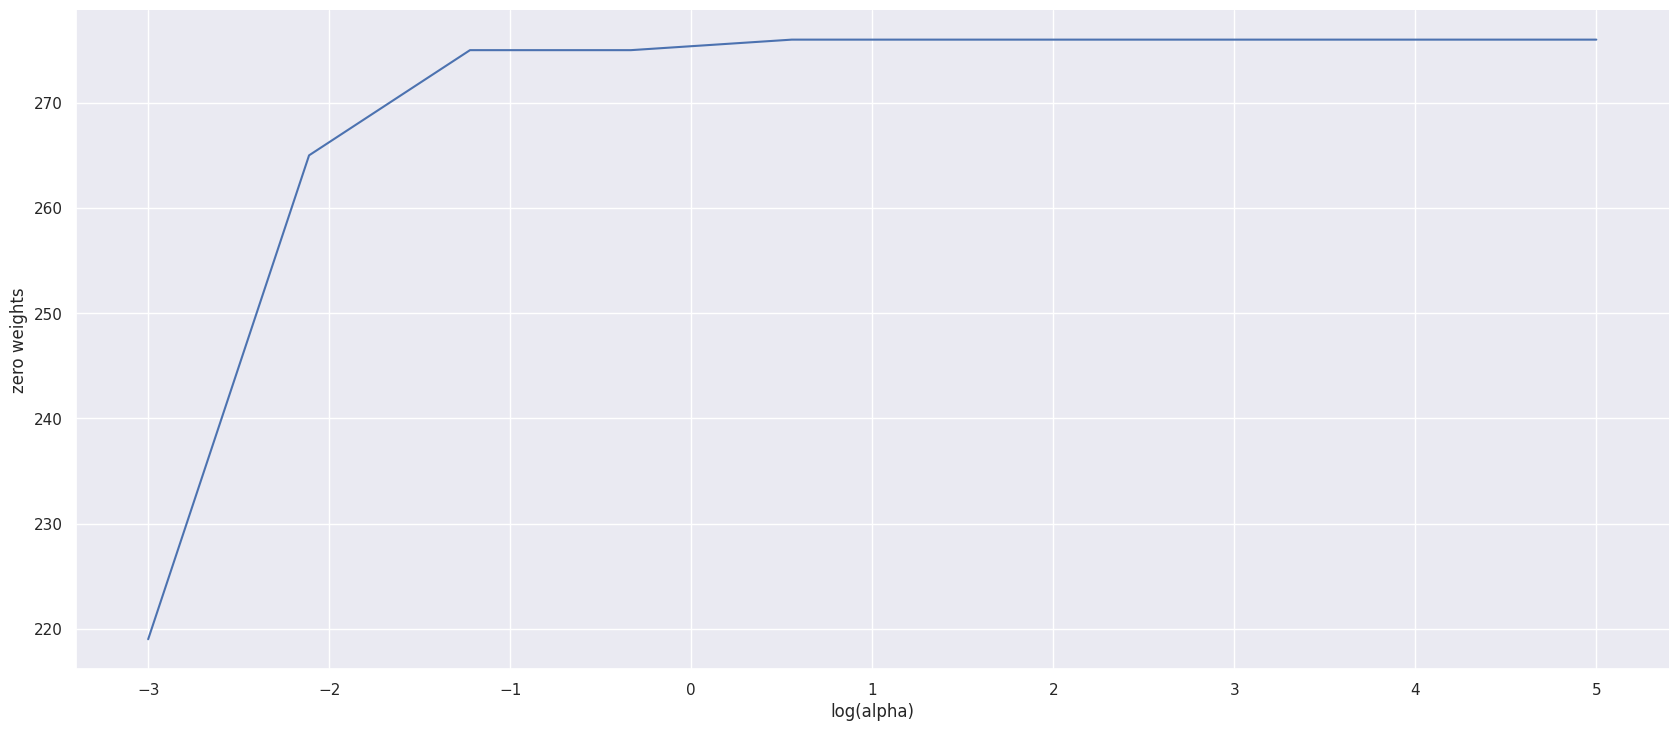

In [160]:
sns.relplot(x=np.log10(values_alpha), y=zero_alpha, kind='line').set(xlabel='log(alpha)', ylabel='zero weights').figure.set_size_inches(20, 8)

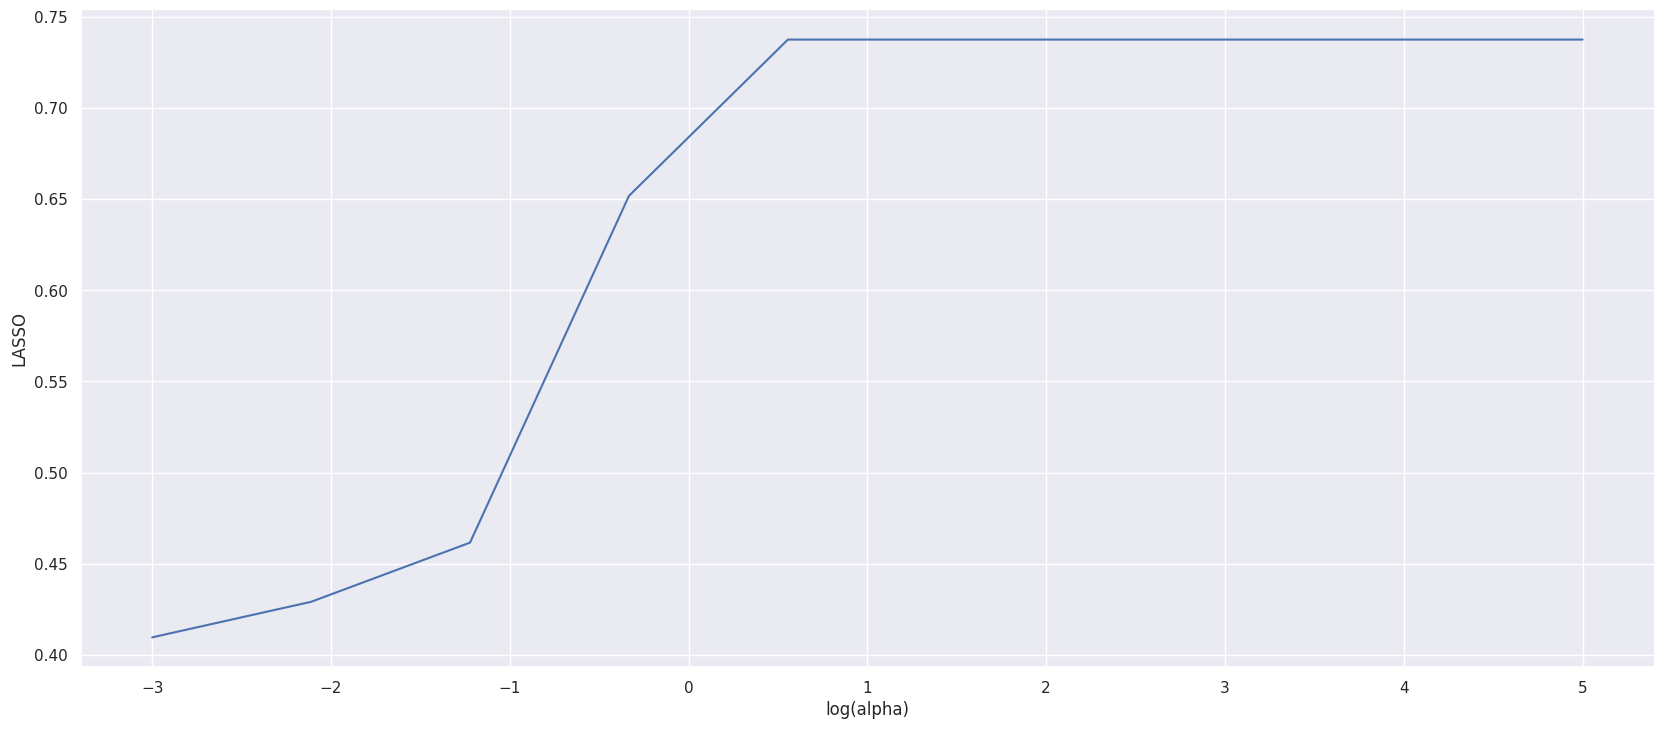

In [161]:
sns.relplot(x=np.log10(values_alpha), y=-cv.cv_results_['mean_test_score'], kind='line').set(xlabel='log(alpha)', ylabel='LASSO').figure.set_size_inches(20, 8)

Видим, что ошибка скакнула с 0.40 до 0.75, что очень много.

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

Картинки не будет, будет [видео.](https://drive.google.com/file/d/1o-tRKZ6tRTLzMn--_v-txrSu189ZZn-U/view?usp=sharing)